In [42]:
import os
import json
import random
import math
import glob
import numpy as np
from tqdm import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.models as models
import cv2

import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
       
VIDEO_DIR = os.path.join("dataset/data/MSRVTT/MSRVTT/videos")  
CAPTIONS_FILE = os.path.join("dataset/data/MSRVTT/MSRVTT/annotation/MSR_VTT.json") 

# Hyperparams (tweak)
SAMPLE_FRAMES = 16       
FEATURE_DIM = 2048       
ENC_HIDDEN = 512
DEC_HIDDEN = 512
EMBED_SIZE = 512
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [ ]:
import numpy as np

file_path = "/kaggle/input/msr-vtt-global-motion-350/global_features/video4.npy"   
data = np.load(file_path, allow_pickle=True)

print("Type:", type(data))
print("Shape:", data.shape)
print("Data type:", data.dtype)

print("\nSample values:\n", data[:4])   # print first 2 items or frames


Type: <class 'numpy.ndarray'>
Shape: (28, 2048)
Data type: float32

Sample values:
 [[8.3046875e+00 4.7924805e-01 3.9154053e-02 ... 6.2500000e+00
  4.6718750e+00 6.2250000e+01]
 [8.3593750e+00 4.7827148e-01 5.8197021e-02 ... 5.8476562e+00
  4.5078125e+00 6.2531250e+01]
 [8.4218750e+00 3.7670898e-01 8.7280273e-02 ... 6.1367188e+00
  4.3828125e+00 6.2468750e+01]
 [8.1640625e+00 3.0639648e-01 3.7322998e-02 ... 5.7851562e+00
  4.2656250e+00 6.0968750e+01]]


In [5]:
import json
import pandas as pd

# Path to your annotation file
anno_file = "/kaggle/input/msr-vtt/MSR_VTT.json"

# Load JSON
with open(anno_file, "r") as f:
    data = json.load(f)

# Convert annotations into DataFrame
df = pd.DataFrame(data["annotations"])

# Show first 5 rows
print(df.head())

                                             caption  id   image_id
0  a cartoon animals runs through an ice cave in ...   0  video2960
1  a cartoon character runs around inside of a vi...   1  video2960
2                 a character is running in the snow   2  video2960
3  a person plays a video game centered around ic...   3  video2960
4       a person plays online and records themselves   4  video2960


In [44]:
#  vocabulary from captions
from nltk.tokenize import word_tokenize

CAPTIONS_FILE = os.path.join("/kaggle/input/msr-vtt/captions.json") 

class Vocab:
    def __init__(self, freq_threshold=1, max_size=None):
        self.freq_threshold = freq_threshold
        self.max_size = max_size
        self.word2idx = {}
        self.idx2word = {}
        self.pad_token = "<PAD>"
        self.bos_token = "<BOS>"
        self.eos_token = "<EOS>"
        self.unk_token = "<UNK>"
        for i,w in enumerate([self.pad_token, self.bos_token, self.eos_token, self.unk_token]):
            self.word2idx[w] = i
        self.idx2word = {i:w for w,i in self.word2idx.items()}

    def build_vocab(self, captions_dict):
        counter = Counter()
        for vid, caps in captions_dict.items():
            for c in caps:
                tokens = [t.lower() for t in word_tokenize(c)]
                counter.update(tokens)
        # filter
        words = [w for w,c in counter.items() if c >= self.freq_threshold]
        words = sorted(words, key=lambda w: (-counter[w], w))
        if self.max_size:
            words = words[:self.max_size - len(self.word2idx)]
        idx = len(self.word2idx)
        for w in words:
            self.word2idx[w] = idx
            self.idx2word[idx] = w
            idx += 1

    def numericalize(self, text):
        tokens = [t.lower() for t in word_tokenize(text)]
        nums = [self.word2idx.get(t, self.word2idx[self.unk_token]) for t in tokens]
        return [self.word2idx[self.bos_token]] + nums + [self.word2idx[self.eos_token]]

# Load captions.json
with open(CAPTIONS_FILE, 'r', encoding='utf-8') as f:
    captions = json.load(f)

vocab = Vocab(freq_threshold=2, max_size=20000)
vocab.build_vocab(captions)
print("Vocab size:", len(vocab.word2idx))


Vocab size: 16834


In [45]:
# Dataset class
FEATURES_DIR = "/kaggle/input/msr-vtt/features/features"
class MSRVTTDataset(Dataset):
    def __init__(self, captions_dict, features_dir, vocab, sample_frames=SAMPLE_FRAMES, max_caption_len=30):
        self.items = []  # (video_filename, caption_text)
        for vid, caps in captions_dict.items():
            for c in caps:
                self.items.append((vid, c))
        self.features_dir = features_dir
        self.vocab = vocab
        self.sample_frames = sample_frames
        self.max_caption_len = max_caption_len

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        vid, cap = self.items[idx]
        feat_path = os.path.join(self.features_dir, vid.replace('.mp4', '.npy'))
        feats = np.load(feat_path)  # (T, D)
        # pad/truncate frames (should already be SAMPLE_FRAMES)
        if feats.shape[0] < self.sample_frames:
            pad = np.zeros((self.sample_frames - feats.shape[0], feats.shape[1]), dtype=np.float32)
            feats = np.concatenate([feats, pad], axis=0)
        else:
            feats = feats[:self.sample_frames]
        numer = self.vocab.numericalize(cap)
        if len(numer) > self.max_caption_len:
            numer = numer[:self.max_caption_len-1] + [self.vocab.word2idx[self.vocab.eos_token]]
        cap_len = len(numer)
        # pad caption
        pad_len = self.max_caption_len - cap_len
        if pad_len > 0:
            numer = numer + [self.vocab.word2idx[self.vocab.pad_token]] * pad_len
        return torch.FloatTensor(feats), torch.LongTensor(numer), cap_len

def collate_fn(batch):
    feats = torch.stack([b[0] for b in batch], dim=0)  # (B, T, D)
    caps = torch.stack([b[1] for b in batch], dim=0)
    cap_lens = torch.LongTensor([b[2] for b in batch])
    return feats, caps, cap_lens

# split dataset (simple random split)
items = list(captions.items())
random.seed(42)
random.shuffle(items)
n = len(items)
train_items = dict(items[:int(0.8*n)])
val_items = dict(items[int(0.8*n):int(0.9*n)])
test_items = dict(items[int(0.9*n):])

train_ds = MSRVTTDataset(train_items, FEATURES_DIR, vocab)
val_ds   = MSRVTTDataset(val_items, FEATURES_DIR, vocab)
test_ds  = MSRVTTDataset(test_items, FEATURES_DIR, vocab)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=4)

print("Train size:", len(train_ds), "Val size:", len(val_ds), "Test size:", len(test_ds))


Train size: 159994 Val size: 20000 Test size: 20000


In [ ]:
#  Model-1)BiLSTM Encoder+LSTM Decoder

class EncoderRNN(nn.Module):
    def __init__(self, feat_size, hidden_size, num_layers=1, bidirectional=True,dropout=0.1):
        super().__init__()
        self.rnn = nn.LSTM(input_size=feat_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.output_size = hidden_size * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, feats):
        # feats: (B, T, D)
        outputs, (h_n, c_n) = self.rnn(feats)  # outputs: (B, T, hidden*dir)
        return outputs, (h_n, c_n)

class LuongAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim):
        super().__init__()
        self.attn = nn.Linear(enc_dim, dec_dim)

    def forward(self, decoder_hidden, encoder_outputs, mask=None):
     
        proj = self.attn(encoder_outputs)  # (B, T, dec_dim)
        # up: (B, T)
        scores = torch.bmm(proj, decoder_hidden.unsqueeze(2)).squeeze(2)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(scores, dim=1)  # (B, T)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (B, enc_dim)
        return context, attn_weights



class DecoderWithAttention(nn.Module):
    def __init__(self, embed_size, enc_dim, dec_hidden, vocab_size, num_layers=1,num_heads=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = LuongAttention(enc_dim, dec_hidden)

        self.lstm = nn.LSTMCell(embed_size + enc_dim, dec_hidden)
        self.fc_out = nn.Linear(dec_hidden, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward_step(self, prev_word, last_hidden, last_cell, encoder_outputs):
        # prev_word: (B,) token ids
        emb = self.embedding(prev_word)  # (B, E)
       
        context, attn_weights = self.attention(last_hidden, encoder_outputs)  # (B, enc_dim), (B, T)

        lstm_input = torch.cat([emb, context], dim=1)
        h, c = self.lstm(lstm_input, (last_hidden, last_cell))
        output = self.fc_out(self.dropout(h))
        return output, h, c, attn_weights

    def forward(self, encoder_outputs, captions, teacher_forcing_ratio=0.9):
        # encoder_outputs: (B, T, enc_dim)
        batch_size = encoder_outputs.size(0)
        max_len = captions.size(1)
        vocab_size = self.fc_out.out_features

        
        hidden = torch.zeros(batch_size, self.lstm.hidden_size, device=encoder_outputs.device)
        cell = torch.zeros(batch_size, self.lstm.hidden_size, device=encoder_outputs.device)

        outputs = torch.zeros(batch_size, max_len, vocab_size, device=encoder_outputs.device)
        attn_weights_all = []

       
        input_word = captions[:,0]  # (B,)
        for t in range(1, max_len):
            out, hidden, cell, attn_weights = self.forward_step(input_word, hidden, cell, encoder_outputs)
            outputs[:, t, :] = out
            attn_weights_all.append(attn_weights)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = out.argmax(1)
            input_word = captions[:, t] if teacher_force else top1
        # outputs: (B, max_len, vocab)
        return outputs, attn_weights_all


In [ ]:
#Decoder model using BiLSTM

class DecoderWithBiLSTM(nn.Module):
    def __init__(self, embed_size, enc_dim, dec_hidden, vocab_size, num_layers=1, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = LuongAttention(enc_dim, dec_hidden * 2)  # since decoder is bidirectional
        
        self.bilstm = nn.LSTM(input_size=embed_size + enc_dim,
                              hidden_size=dec_hidden,
                              num_layers=num_layers,
                              batch_first=True,
                              bidirectional=True)
        
        self.fc_out = nn.Linear(dec_hidden * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, encoder_outputs, captions, teacher_forcing_ratio=0.9):
        # encoder_outputs: (B, T, enc_dim)
        batch_size = encoder_outputs.size(0)
        max_len = captions.size(1)
        vocab_size = self.fc_out.out_features

        # Initialize hidden and cell states for both directions
        h0 = torch.zeros(2, batch_size, self.bilstm.hidden_size, device=encoder_outputs.device)
        c0 = torch.zeros(2, batch_size, self.bilstm.hidden_size, device=encoder_outputs.device)

        # Embedding all captions
        embeddings = self.embedding(captions)  # (B, L, E)
        outputs = torch.zeros(batch_size, max_len, vocab_size, device=encoder_outputs.device)
        attn_weights_all = []

        # Loop through each timestep (teacher forcing)
        input_word = captions[:, 0]  # <BOS> token
        hidden, cell = h0, c0

        for t in range(1, max_len):
            emb = self.embedding(input_word).unsqueeze(1)  # (B,1,E)
            
           
            # Combine both directions' last layer hidden states
            last_hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)  # (B, dec_hidden*2)
            context, attn_weights = self.attention(last_hidden_cat, encoder_outputs)
            attn_weights_all.append(attn_weights)

            # Concatenate embedding and context
            lstm_input = torch.cat([emb, context.unsqueeze(1)], dim=2)  # (B,1,E+enc_dim)

            # Run one BiLSTM step (we process one token at a time)
            output, (hidden, cell) = self.bilstm(lstm_input, (hidden, cell))  # output: (B,1,2*hidden)

            # Generate next word prediction
            out_vocab = self.fc_out(self.dropout(output.squeeze(1)))  # (B, vocab)
            outputs[:, t, :] = out_vocab

            # Decide whether to use teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = out_vocab.argmax(1)
            input_word = captions[:, t] if teacher_force else top1

        return outputs, attn_weights_all


Initilaization of Encoder and Decoder

In [ ]:

enc = EncoderRNN(feat_size=FEATURE_DIM, hidden_size=ENC_HIDDEN, bidirectional=True).to(DEVICE)
# dec = DecoderWithAttention(embed_size=EMBED_SIZE, enc_dim=enc.output_size, dec_hidden=DEC_HIDDEN, vocab_size=len(vocab.word2idx)).to(DEVICE)
dec = DecoderWithBiLSTM(embed_size=EMBED_SIZE, enc_dim=enc.output_size, dec_hidden=DEC_HIDDEN, vocab_size=len(vocab.word2idx)).to(DEVICE)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1,ignore_index=vocab.word2idx[vocab.pad_token])
params = list(enc.parameters()) + list(dec.parameters())
optimizer = optim.Adam(params, lr=LR)

def train_one_epoch(train_loader, enc, dec, optimizer, criterion, device, clip=5.0):
    enc.train(); dec.train()
    running_loss = 0.0
    for feats, caps, cap_lens in tqdm(train_loader):
        feats = feats.to(device)            # (B, T, D)
        caps = caps.to(device)              # (B, L)
        optimizer.zero_grad()
        encoder_outs, _ = enc(feats)       # (B, T, enc_dim)
        outputs, _ = dec(encoder_outs, caps, teacher_forcing_ratio=0.75)  # (B, L, V)
        # shift outputs and targets: ignore the first token (<BOS>)
        outputs = outputs[:,1:,:].contiguous()
        targets = caps[:,1:].contiguous()
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params, clip)
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate(loader, enc, dec, device):
    enc.eval(); dec.eval()
    all_refs = []
    all_preds = []
    with torch.no_grad():
        for feats, caps, cap_lens in tqdm(loader):
            feats = feats.to(device)
            caps = caps.to(device)
            encoder_outs, _ = enc(feats)
            # greedy decode
            batch_size = feats.size(0)
            hidden = torch.zeros(batch_size, dec.lstm.hidden_size, device=device)
            cell   = torch.zeros(batch_size, dec.lstm.hidden_size, device=device)
            input_word = torch.LongTensor([vocab.word2idx[vocab.bos_token]] * batch_size).to(device)
            preds = [[] for _ in range(batch_size)]
            for t in range(1, caps.size(1)):
                out, hidden, cell, attn = dec.forward_step(input_word, hidden, cell, encoder_outs)
                top1 = out.argmax(1)  # (B,)
                input_word = top1
                for i in range(batch_size):
                    preds[i].append(decoder_token := top1[i].item())
            # convert preds and refs to token lists
            for i in range(batch_size):
                # predicted sentence until EOS or max len
                p = []
                for tok in preds[i]:
                    if tok == vocab.word2idx[vocab.eos_token]:
                        break
                    if tok == vocab.word2idx[vocab.pad_token] or tok == vocab.word2idx[vocab.bos_token]:
                        continue
                    p.append(vocab.idx2word.get(tok, vocab.unk_token))
                all_preds.append(p)
              
                ref_tokens = []
                target_seq = caps[i].cpu().numpy()
                for tok in target_seq:
                    if tok == vocab.word2idx[vocab.eos_token]:
                        break
                    if tok in (vocab.word2idx[vocab.bos_token], vocab.word2idx[vocab.pad_token]):
                        continue
                    ref_tokens.append(vocab.idx2word.get(int(tok), vocab.unk_token))
                all_refs.append([ref_tokens])
    # BLEU
    smoothie = SmoothingFunction().method4
    bleu4 = corpus_bleu(all_refs, all_preds, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)
    return bleu4, all_refs, all_preds


In [ ]:
import torch
from tqdm import tqdm
import random
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge import Rouge
from pycocoevalcap.cider.cider import Cider

def evaluate_with_metrics(loader, enc, dec, vocab, device, DEC_HIDDEN=512):
    enc.eval()
    dec.eval()
    all_refs, all_preds = [], []
    
    rouge = Rouge()
    cider_scorer = Cider()

    with torch.no_grad():
        for feats, caps, cap_lens in tqdm(loader, desc="Evaluating"):
            feats, caps = feats.to(device), caps.to(device)
            B = feats.size(0)
            
            # Encoder forward
            encoder_outs, _ = enc(feats)

            # Initialize hidden and cell
            hidden = torch.zeros(B, DEC_HIDDEN, device=device)
            cell = torch.zeros(B, DEC_HIDDEN, device=device)
            
            # Start with <BOS> token
            input_word = torch.LongTensor([vocab.word2idx[vocab.bos_token]] * B).to(device)

            preds = [[] for _ in range(B)]

            # Greedy decoding
            max_len = caps.size(1)
            for t in range(1, max_len):
                out, hidden, cell, attn_weights = dec.forward_step(
                    input_word, hidden, cell, encoder_outs
                )
                top1 = out.argmax(1)
                input_word = top1
                for i in range(B):
                    preds[i].append(top1[i].item())

            # Convert predicted tokens → words
            for i in range(B):
                pred_tokens = []
                for tok in preds[i]:
                    if tok in (vocab.word2idx[vocab.pad_token], vocab.word2idx[vocab.bos_token]):
                        continue
                    if tok == vocab.word2idx[vocab.eos_token]:
                        break
                    pred_tokens.append(vocab.idx2word.get(tok, vocab.unk_token))
                all_preds.append(pred_tokens)

                # Reference captions
                ref_tokens = []
                for tok in caps[i].cpu().numpy():
                    if tok in (vocab.word2idx[vocab.pad_token], vocab.word2idx[vocab.bos_token]):
                        continue
                    if tok == vocab.word2idx[vocab.eos_token]:
                        break
                    ref_tokens.append(vocab.idx2word.get(int(tok), vocab.unk_token))
                all_refs.append([ref_tokens])

   
    # Compute Metrics
 
    smoothie = SmoothingFunction().method4
    bleu4 = corpus_bleu(all_refs, all_preds, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    refs_str = [' '.join(ref[0]) for ref in all_refs]
    preds_str = [' '.join(pred) for pred in all_preds]

    rouge_scores = rouge.get_scores(preds_str, refs_str, avg=True)
    cider_score, _ = cider_scorer.compute_score(
        {i: [refs_str[i]] for i in range(len(refs_str))},
        {i: [preds_str[i]] for i in range(len(preds_str))}
    )

    print(f"\nBLEU-4: {bleu4:.4f}")
    print(f"ROUGE-L: {rouge_scores['rouge-l']['f']:.4f}")
    print(f"CIDEr: {cider_score:.4f}")

    return bleu4, rouge_scores, cider_score, all_refs, all_preds


Training and testing 1st Model BiLSTM Enc & LSTM Dec +Luong +label smoothing+dropout+all 3 metrics

In [ ]:
#Training Loop

best_bleu = 0.0

for epoch in range(1, EPOCHS + 1):
    #Training 
    train_loss = train_one_epoch(train_loader, enc, dec, optimizer, criterion, DEVICE)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f}")
    
    # Validation 
    bleu, rouge_scores, cider, _, _ = evaluate_with_metrics(val_loader, enc, dec, vocab, DEVICE, DEC_HIDDEN)
    rouge_l_f = rouge_scores['rouge-l']['f']  
    
    print(f"[Epoch {epoch}] Validation Metrics:")
    print(f"  BLEU-4 = {bleu:.4f}")
    print(f"  ROUGE-L (F1) = {rouge_l_f:.4f}")
    print(f"  CIDEr = {cider:.4f}")
    
 
    if bleu > best_bleu:
        best_bleu = bleu
        torch.save({
            'enc_state': enc.state_dict(),
            'dec_state': dec.state_dict(),
            'vocab': vocab.word2idx
        }, "best_checkpoint.pth")
        print("✅ Saved new best checkpoint.")

print(f"\nTraining complete. Best BLEU-4 achieved: {best_bleu:.4f}")


100%|██████████| 5000/5000 [11:12<00:00,  7.43it/s]


Epoch 1 | Train Loss: 4.6179


Evaluating: 100%|██████████| 625/625 [00:26<00:00, 23.21it/s]



BLEU-4: 0.0518
ROUGE-L: 0.2815
CIDEr: 0.4819
[Epoch 1] Validation Metrics:
  BLEU-4 = 0.0518
  ROUGE-L (F1) = 0.2815
  CIDEr = 0.4819
✅ Saved new best checkpoint.


100%|██████████| 5000/5000 [11:11<00:00,  7.44it/s]


Epoch 2 | Train Loss: 4.5586


Evaluating: 100%|██████████| 625/625 [00:26<00:00, 23.34it/s]



BLEU-4: 0.0508
ROUGE-L: 0.2812
CIDEr: 0.4880
[Epoch 2] Validation Metrics:
  BLEU-4 = 0.0508
  ROUGE-L (F1) = 0.2812
  CIDEr = 0.4880


100%|██████████| 5000/5000 [11:11<00:00,  7.44it/s]


Epoch 3 | Train Loss: 4.5077


Evaluating: 100%|██████████| 625/625 [00:26<00:00, 23.21it/s]



BLEU-4: 0.0514
ROUGE-L: 0.2843
CIDEr: 0.4896
[Epoch 3] Validation Metrics:
  BLEU-4 = 0.0514
  ROUGE-L (F1) = 0.2843
  CIDEr = 0.4896


100%|██████████| 5000/5000 [11:11<00:00,  7.44it/s]


Epoch 4 | Train Loss: 4.4580


Evaluating: 100%|██████████| 625/625 [00:27<00:00, 23.10it/s]



BLEU-4: 0.0522
ROUGE-L: 0.2825
CIDEr: 0.4988
[Epoch 4] Validation Metrics:
  BLEU-4 = 0.0522
  ROUGE-L (F1) = 0.2825
  CIDEr = 0.4988
✅ Saved new best checkpoint.


100%|██████████| 5000/5000 [11:13<00:00,  7.43it/s]


Epoch 5 | Train Loss: 4.4123


Evaluating: 100%|██████████| 625/625 [00:26<00:00, 23.39it/s]



BLEU-4: 0.0520
ROUGE-L: 0.2801
CIDEr: 0.4963
[Epoch 5] Validation Metrics:
  BLEU-4 = 0.0520
  ROUGE-L (F1) = 0.2801
  CIDEr = 0.4963


100%|██████████| 5000/5000 [11:12<00:00,  7.43it/s]


Epoch 6 | Train Loss: 4.3873


Evaluating: 100%|██████████| 625/625 [00:26<00:00, 23.29it/s]



BLEU-4: 0.0527
ROUGE-L: 0.2824
CIDEr: 0.5100
[Epoch 6] Validation Metrics:
  BLEU-4 = 0.0527
  ROUGE-L (F1) = 0.2824
  CIDEr = 0.5100
✅ Saved new best checkpoint.


100%|██████████| 5000/5000 [11:13<00:00,  7.43it/s]


Epoch 7 | Train Loss: 4.3469


Evaluating: 100%|██████████| 625/625 [00:26<00:00, 23.24it/s]



BLEU-4: 0.0520
ROUGE-L: 0.2805
CIDEr: 0.4878
[Epoch 7] Validation Metrics:
  BLEU-4 = 0.0520
  ROUGE-L (F1) = 0.2805
  CIDEr = 0.4878


100%|██████████| 5000/5000 [11:13<00:00,  7.42it/s]


Epoch 8 | Train Loss: 4.3162


Evaluating: 100%|██████████| 625/625 [00:26<00:00, 23.32it/s]



BLEU-4: 0.0524
ROUGE-L: 0.2831
CIDEr: 0.4952
[Epoch 8] Validation Metrics:
  BLEU-4 = 0.0524
  ROUGE-L (F1) = 0.2831
  CIDEr = 0.4952


100%|██████████| 5000/5000 [11:13<00:00,  7.43it/s]


Epoch 9 | Train Loss: 4.2777


Evaluating: 100%|██████████| 625/625 [00:27<00:00, 23.02it/s]



BLEU-4: 0.0523
ROUGE-L: 0.2834
CIDEr: 0.5080
[Epoch 9] Validation Metrics:
  BLEU-4 = 0.0523
  ROUGE-L (F1) = 0.2834
  CIDEr = 0.5080


100%|██████████| 5000/5000 [11:13<00:00,  7.42it/s]


Epoch 10 | Train Loss: 4.2576


Evaluating: 100%|██████████| 625/625 [00:26<00:00, 23.29it/s]



BLEU-4: 0.0535
ROUGE-L: 0.2810
CIDEr: 0.4992
[Epoch 10] Validation Metrics:
  BLEU-4 = 0.0535
  ROUGE-L (F1) = 0.2810
  CIDEr = 0.4992
✅ Saved new best checkpoint.

Training complete. Best BLEU-4 achieved: 0.0535


In [ ]:
import torch
import numpy as np
import os
import random
from tqdm import tqdm

# Load the best saved checkpoint

ckpt = torch.load("best_checkpoint.pth", map_location=DEVICE)
enc.load_state_dict(ckpt['enc_state'])
dec.load_state_dict(ckpt['dec_state'])
print(" Loaded checkpoint successfully.")



# Evaluate on test set

print("Running test evaluation (BLEU, ROUGE, CIDEr)...")
test_bleu, test_rouge, test_cider ,_,_= evaluate_with_metrics(test_loader, enc, dec, vocab, DEVICE,DEC_HIDDEN)
# Extract the ROUGE-L F1 score
test_rouge_l = test_rouge['rouge-l']['f']

print(f"\n📊 Test Metrics:")
print(f"BLEU-4  = {test_bleu:.4f}")
print(f"ROUGE-L = {test_rouge_l:.4f}")
print(f"CIDEr   = {test_cider:.4f}")



def generate_caption_for_video(video_feat, enc, dec, vocab, device, max_len=20):
    enc.eval()
    dec.eval()

    feat_tensor = torch.tensor(video_feat).unsqueeze(0).float().to(device)  # (1, T, D)
    with torch.no_grad():
        
        encoder_outs, _ = enc(feat_tensor)

        hidden = torch.zeros(1, dec.lstm.hidden_size, device=device)
        cell = torch.zeros(1, dec.lstm.hidden_size, device=device)

        input_word = torch.LongTensor([vocab.word2idx[vocab.bos_token]]).to(device)
        generated_tokens = []

        for _ in range(max_len):
            out, hidden, cell, attn_weights = dec.forward_step(
                input_word, hidden, cell, encoder_outs
            )
            next_word = out.argmax(1).item()

            if next_word == vocab.word2idx[vocab.eos_token]:
                break

            generated_tokens.append(vocab.idx2word.get(next_word, vocab.unk_token))
            input_word = torch.LongTensor([next_word]).to(device)

    return " ".join(generated_tokens)


# few random test samples

sample_videos = random.sample(list(test_items.keys()), 4)

print("\n --- Random Sample Predictions ---")
for i, vid in enumerate(sample_videos):
    sample_feat_path = os.path.join(FEATURES_DIR, vid.replace('.mp4', '.npy'))
    sample_feat = np.load(sample_feat_path)

    generated_caption = generate_caption_for_video(sample_feat, enc, dec, vocab, DEVICE)
    references = test_items[vid]  

    print(f"\n Video {i+1}: {vid}")
    print(f"Generated Caption: {generated_caption}")
    print("Reference Captions:")
    for j, ref in enumerate(references[:3]):  
        print(f"  Ref {j+1}: {ref}")


 Loaded checkpoint successfully.
Running test evaluation (BLEU, ROUGE, CIDEr)...


Evaluating: 100%|██████████| 625/625 [00:26<00:00, 23.39it/s]



BLEU-4: 0.0523
ROUGE-L: 0.2775
CIDEr: 0.5009

📊 Test Metrics:
BLEU-4  = 0.0523
ROUGE-L = 0.2775
CIDEr   = 0.5009

 --- Random Sample Predictions ---

 Video 1: video6643.mp4
Generated Caption: a man is talking to a man
Reference Captions:
  Ref 1: a clip showing a man giving instructions to others
  Ref 2: a guy is giving a speech in front of an audience
  Ref 3: a man giving a motavational speech

 Video 2: video1850.mp4
Generated Caption: a man in a suit is talking to a man in a suit
Reference Captions:
  Ref 1: a gray haired news anchor with a purple tie discusses an election
  Ref 2: there is a suit man is talking about election
  Ref 3: there is a suit man is talking about politics

 Video 3: video4829.mp4
Generated Caption: a woman is talking to a woman
Reference Captions:
  Ref 1: a couple is singing different parts of the same song
  Ref 2: a couple is watching a movie
  Ref 3: a couple singing a song

 Video 4: video8925.mp4
Generated Caption: a band is performing a song
Refe

In [ ]:
#BiLSTM Encoder(+dropout) decoder+ label smoothening
#  Training loop
EPOCHS=15
best_bleu = 0.0
for epoch in range(1, EPOCHS+1):
    train_loss = train_one_epoch(train_loader, enc, dec, optimizer, criterion, DEVICE)
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")
    bleu, _, _ = evaluate(val_loader, enc, dec, DEVICE)
    print(f"Validation BLEU-4: {bleu:.4f}")
    if bleu > best_bleu:
        best_bleu = bleu
        torch.save({
            'enc_state': enc.state_dict(),
            'dec_state': dec.state_dict(),
            'vocab': vocab.word2idx
        }, "best_checkpoint.pth")
        print("Saved best checkpoint.")


100%|██████████| 5000/5000 [09:54<00:00,  8.41it/s]


Epoch 1 train loss: 5.5310


100%|██████████| 625/625 [00:26<00:00, 24.03it/s]


Validation BLEU-4: 0.0371
Saved best checkpoint.


100%|██████████| 5000/5000 [09:53<00:00,  8.42it/s]


Epoch 2 train loss: 5.0404


100%|██████████| 625/625 [00:26<00:00, 23.81it/s]


Validation BLEU-4: 0.0438
Saved best checkpoint.


100%|██████████| 5000/5000 [09:55<00:00,  8.40it/s]


Epoch 3 train loss: 4.8488


100%|██████████| 625/625 [00:25<00:00, 24.22it/s]


Validation BLEU-4: 0.0483
Saved best checkpoint.


100%|██████████| 5000/5000 [09:55<00:00,  8.40it/s]


Epoch 4 train loss: 4.7271


100%|██████████| 625/625 [00:26<00:00, 23.75it/s]


Validation BLEU-4: 0.0499
Saved best checkpoint.


100%|██████████| 5000/5000 [09:55<00:00,  8.40it/s]


Epoch 5 train loss: 4.6339


100%|██████████| 625/625 [00:25<00:00, 24.04it/s]


Validation BLEU-4: 0.0479


100%|██████████| 5000/5000 [09:55<00:00,  8.40it/s]


Epoch 6 train loss: 4.5579


100%|██████████| 625/625 [00:26<00:00, 23.84it/s]


Validation BLEU-4: 0.0494


100%|██████████| 5000/5000 [09:56<00:00,  8.39it/s]


Epoch 7 train loss: 4.4987


100%|██████████| 625/625 [00:25<00:00, 24.05it/s]


Validation BLEU-4: 0.0522
Saved best checkpoint.


100%|██████████| 5000/5000 [09:54<00:00,  8.40it/s]


Epoch 8 train loss: 4.4506


100%|██████████| 625/625 [00:26<00:00, 23.63it/s]


Validation BLEU-4: 0.0518


100%|██████████| 5000/5000 [09:55<00:00,  8.40it/s]


Epoch 9 train loss: 4.4010


100%|██████████| 625/625 [00:26<00:00, 23.92it/s]


Validation BLEU-4: 0.0489


100%|██████████| 5000/5000 [09:54<00:00,  8.40it/s]


Epoch 10 train loss: 4.3578


100%|██████████| 625/625 [00:26<00:00, 24.04it/s]


Validation BLEU-4: 0.0514


100%|██████████| 5000/5000 [09:53<00:00,  8.43it/s]


Epoch 11 train loss: 4.3314


100%|██████████| 625/625 [00:26<00:00, 23.96it/s]


Validation BLEU-4: 0.0520


 17%|█▋        | 865/5000 [01:43<08:20,  8.27it/s]

In [18]:
#  Greedy inference for a single video, and test BLEU
def generate_caption_for_video(feat_np, enc, dec, vocab, device, max_len=30):
    enc.eval(); dec.eval()
    with torch.no_grad():
        feats = torch.FloatTensor(feat_np).unsqueeze(0).to(device)  # (1, T, D)
        encoder_outs, _ = enc(feats)
        hidden = torch.zeros(1, dec.lstm.hidden_size, device=device)
        cell   = torch.zeros(1, dec.lstm.hidden_size, device=device)
        input_word = torch.LongTensor([vocab.word2idx[vocab.bos_token]]).to(device)
        pred_tokens = []
        for t in range(max_len):
            out, hidden, cell, attn = dec.forward_step(input_word, hidden, cell, encoder_outs)
            top1 = out.argmax(1).item()
            if top1 == vocab.word2idx[vocab.eos_token]:
                break
            if top1 not in (vocab.word2idx[vocab.pad_token], vocab.word2idx[vocab.bos_token]):
                pred_tokens.append(vocab.idx2word.get(top1, vocab.unk_token))
            input_word = torch.LongTensor([top1]).to(device)
    return " ".join(pred_tokens)

# Load checkpoint and test
ckpt = torch.load("best_checkpoint.pth", map_location=DEVICE)
enc.load_state_dict(ckpt['enc_state'])
dec.load_state_dict(ckpt['dec_state'])
print("Loaded checkpoint. Running test evaluation (BLEU-4)...")
test_bleu, refs, preds = evaluate(test_loader, enc, dec, DEVICE)
print("Test BLEU-4:", test_bleu)


sample_feat_path = os.path.join(FEATURES_DIR, list(test_items.keys())[0].replace('.mp4', '.npy'))
sample_feat = np.load(sample_feat_path)
print("Generated:", generate_caption_for_video(sample_feat, enc, dec, vocab, DEVICE))
print("Reference(s):", test_items[list(test_items.keys())[0]][:3])  # first few refs

Loaded checkpoint. Running test evaluation (BLEU-4)...


100%|██████████| 625/625 [00:25<00:00, 24.73it/s]


Test BLEU-4: 0.05059154183767522
Generated: a man is talking about a
Reference(s): ['a late night talk show host speaking', 'a man is asking people to make predictions', 'a man is giving speech']


In [ ]:
# lstm(+dropout)
ckpt = torch.load("best_checkpoint.pth", map_location=DEVICE)
enc.load_state_dict(ckpt['enc_state'])
dec.load_state_dict(ckpt['dec_state'])
print("Loaded checkpoint. Running test evaluation (BLEU-4)...")
test_bleu, refs, preds = evaluate(test_loader, enc, dec, DEVICE)
print("Test BLEU-4:", test_bleu)

# Show results for 3–4 videos
print("\n--- Sample Predictions ---")
for i, vid in enumerate(list(test_items.keys())[:4]):  # first 4 test videos
    sample_feat_path = os.path.join(FEATURES_DIR, vid.replace('.mp4', '.npy'))
    sample_feat = np.load(sample_feat_path)

    # Generate caption
    generated = generate_caption_for_video(sample_feat, enc, dec, vocab, DEVICE)

    # Print result
    print(f"\nVideo {i+1}: {vid}")
    print("Generated:", generated)
    print("Reference(s):", test_items[vid][:3])  # show first 3 references


Loaded checkpoint. Running test evaluation (BLEU-4)...


100%|██████████| 625/625 [00:25<00:00, 24.25it/s]


Test BLEU-4: 0.05059154183767522

--- Sample Predictions ---

Video 1: video2972.mp4
Generated: a man is talking about a
Reference(s): ['a late night talk show host speaking', 'a man is asking people to make predictions', 'a man is giving speech']

Video 2: video7381.mp4
Generated: a girl is singing on stage
Reference(s): ['a boy singing in the stage', 'a couple preforms a song on stage', 'a group is singing a song']

Video 3: video6018.mp4
Generated: a cartoon is playing with a
Reference(s): ['a group of people near a pool', 'a man is clapping', 'a puppet is climbing a diving board ladder']

Video 4: video7663.mp4
Generated: a man and woman are dancing
Reference(s): ['a woman sings a country song about her shoes and love', 'performers are dancing on the stage while blue spotlight scans the audience', 'people dance around on a stage in front of an audience']


In [23]:
import random

# Load checkpoint and test
ckpt = torch.load("best_checkpoint.pth", map_location=DEVICE)
enc.load_state_dict(ckpt['enc_state'])
dec.load_state_dict(ckpt['dec_state'])
print("Loaded checkpoint. Running test evaluation (BLEU-4)...")
test_bleu, refs, preds = evaluate(test_loader, enc, dec, DEVICE)
print("Test BLEU-4:", test_bleu)

# Pick 4 random test videos
sample_videos = random.sample(list(test_items.keys()), 4)

print("\n--- Random Sample Predictions ---")
for i, vid in enumerate(sample_videos):
    sample_feat_path = os.path.join(FEATURES_DIR, vid.replace('.mp4', '.npy'))
    sample_feat = np.load(sample_feat_path)

    # Generate caption
    generated = generate_caption_for_video(sample_feat, enc, dec, vocab, DEVICE)

    # References (original captions)
    references = test_items[vid]

    print(f"\nVideo {i+1}: {vid}")
    print("Generated Caption:", generated)
    print("Original Captions:")
    for j, ref in enumerate(references[:3]):  # show first 3 refs
        print(f"  Ref {j+1}: {ref}")


Loaded checkpoint. Running test evaluation (BLEU-4)...


100%|██████████| 625/625 [00:25<00:00, 24.97it/s]


Test BLEU-4: 0.05059154183767522

--- Random Sample Predictions ---

Video 1: video5438.mp4
Generated Caption: a cartoon is showing a cartoon
Original Captions:
  Ref 1: there is a boy with cap is dancing on the floor
  Ref 2: long time no see the trailer of the smurfs-2 in 3d
  Ref 3: the cartoon character smurfs is blue in colour and wearing white pant and shoes

Video 2: video5879.mp4
Generated Caption: a person is using a toy
Original Captions:
  Ref 1: a girl is being cut out of paper
  Ref 2: a man cuts material with scissors
  Ref 3: a man showing his craft skills

Video 3: video7557.mp4
Generated Caption: a girl is playing guitar and singing
Original Captions:
  Ref 1: a girl singing a song with an acoustic guitar outside
  Ref 2: this asian lady with a guitar is singing a song on the side of the street
  Ref 3: a blue shirt lady is playing guitar on the road

Video 4: video520.mp4
Generated Caption: a cartoon character is talking to a cartoon
Original Captions:
  Ref 1: a cart

In [ ]:
#BiLSTM
import torch
from tqdm import tqdm
import random
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge import Rouge
from pycocoevalcap.cider.cider import Cider

def evaluate_with_metrics(loader, enc, dec, vocab, device):
    enc.eval()
    dec.eval()
    all_refs, all_preds = [], []
    
    rouge = Rouge()
    cider_scorer = Cider()

    with torch.no_grad():
        for feats, caps, cap_lens in tqdm(loader, desc="Evaluating"):
            feats, caps = feats.to(device), caps.to(device)
            B = feats.size(0)

            # Encoder Forward
            encoder_outs, _ = enc(feats)  # (B, T, enc_dim)

            # Initialize hidden states for BiLSTM
            num_directions = 2
            hidden_size = dec.bilstm.hidden_size
            num_layers = dec.bilstm.num_layers

            hidden = torch.zeros(num_layers * num_directions, B, hidden_size, device=device)
            cell = torch.zeros(num_layers * num_directions, B, hidden_size, device=device)

    
            #  Start decoding
            input_word = torch.LongTensor([vocab.word2idx[vocab.bos_token]] * B).to(device)
            preds = [[] for _ in range(B)]

            max_len = caps.size(1)

            for t in range(1, max_len):
                emb = dec.embedding(input_word).unsqueeze(1)  # (B,1,E)

                # Combine forward and backward hidden states from the last layer
                last_hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)  # (B, dec_hidden*2)

                # Attention over encoder outputs
                context, attn_weights = dec.attention(last_hidden_cat, encoder_outs)

              
                lstm_input = torch.cat([emb, context.unsqueeze(1)], dim=2)

                # One decoding step
                output, (hidden, cell) = dec.bilstm(lstm_input, (hidden, cell))
                out_vocab = dec.fc_out(dec.dropout(output.squeeze(1)))  # (B, vocab_size)

                # Greedy decoding
                top1 = out_vocab.argmax(1)
                input_word = top1

                for i in range(B):
                    preds[i].append(top1[i].item())

       
            #  Convert Predictions & References to Tokens
            for i in range(B):
                pred_tokens = []
                for tok in preds[i]:
                    if tok in (vocab.word2idx[vocab.pad_token], vocab.word2idx[vocab.bos_token]):
                        continue
                    if tok == vocab.word2idx[vocab.eos_token]:
                        break
                    pred_tokens.append(vocab.idx2word.get(tok, vocab.unk_token))
                all_preds.append(pred_tokens)

                ref_tokens = []
                for tok in caps[i].cpu().numpy():
                    if tok in (vocab.word2idx[vocab.pad_token], vocab.word2idx[vocab.bos_token]):
                        continue
                    if tok == vocab.word2idx[vocab.eos_token]:
                        break
                    ref_tokens.append(vocab.idx2word.get(int(tok), vocab.unk_token))
                all_refs.append([ref_tokens])

  
    #  Compute Evaluation Metrics
    smoothie = SmoothingFunction().method4
    bleu4 = corpus_bleu(all_refs, all_preds, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    refs_str = [' '.join(ref[0]) for ref in all_refs]
    preds_str = [' '.join(pred) for pred in all_preds]

    rouge_scores = rouge.get_scores(preds_str, refs_str, avg=True)
    cider_score, _ = cider_scorer.compute_score(
        {i: [refs_str[i]] for i in range(len(refs_str))},
        {i: [preds_str[i]] for i in range(len(preds_str))}
    )

    print(f"\nBLEU-4: {bleu4:.4f}")
    print(f"ROUGE-L: {rouge_scores['rouge-l']['f']:.4f}")
    print(f"CIDEr: {cider_score:.4f}")

    return bleu4, rouge_scores, cider_score, all_refs, all_preds


In [ ]:
def train_one_epoch(train_loader, enc, dec, optimizer, criterion, device, clip=5.0):
    enc.train()
    dec.train()
    running_loss = 0.0

    for feats, caps, cap_lens in tqdm(train_loader, desc="Training"):
        feats = feats.to(device)          # (B, T, D)
        caps = caps.to(device)            # (B, L)
        optimizer.zero_grad()

   
        # Encoder forward
        encoder_outs, _ = enc(feats)      # (B, T, enc_dim)


        # Decoder forward (BiLSTM)
        outputs, _ = dec(encoder_outs, caps, teacher_forcing_ratio=0.75)  # (B, L, V)


        # Ignore the <BOS> token
        outputs = outputs[:, 1:, :].contiguous()
        targets = caps[:, 1:].contiguous()

        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
        loss.backward()

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(list(enc.parameters()) + list(dec.parameters()), clip)

        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(train_loader)


In [ ]:
#Decder-BiLSTM 
#Training Loop

best_bleu = 0.0

for epoch in range(1, EPOCHS + 1):
    # Training 
    train_loss = train_one_epoch(train_loader, enc, dec, optimizer, criterion, DEVICE)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f}")
    
    # Validation
    bleu, rouge_scores, cider, _, _ = evaluate_with_metrics(val_loader, enc, dec, vocab, DEVICE)
    rouge_l_f = rouge_scores['rouge-l']['f']
    
    print(f"[Epoch {epoch}] Validation Metrics:")
    print(f"  BLEU-4 = {bleu:.4f}")
    print(f"  ROUGE-L (F1) = {rouge_l_f:.4f}")
    print(f"  CIDEr = {cider:.4f}")
    
  
    if bleu > best_bleu:
        best_bleu = bleu
        torch.save({
            'enc_state': enc.state_dict(),
            'dec_state': dec.state_dict(),
            'vocab': vocab.word2idx
        }, "best_checkpoint.pth")
        print(" Saved new best checkpoint.")

print(f"\nTraining complete. Best BLEU-4 achieved: {best_bleu:.4f}")


Training: 100%|██████████| 5000/5000 [16:53<00:00,  4.93it/s]


Epoch 1 | Train Loss: 5.4230


Evaluating: 100%|██████████| 625/625 [00:37<00:00, 16.74it/s]



BLEU-4: 0.0379
ROUGE-L: 0.2682
CIDEr: 0.3723
[Epoch 1] Validation Metrics:
  BLEU-4 = 0.0379
  ROUGE-L (F1) = 0.2682
  CIDEr = 0.3723
 Saved new best checkpoint.


Training: 100%|██████████| 5000/5000 [16:54<00:00,  4.93it/s]


Epoch 2 | Train Loss: 4.9368


Evaluating: 100%|██████████| 625/625 [00:37<00:00, 16.70it/s]



BLEU-4: 0.0461
ROUGE-L: 0.2745
CIDEr: 0.4435
[Epoch 2] Validation Metrics:
  BLEU-4 = 0.0461
  ROUGE-L (F1) = 0.2745
  CIDEr = 0.4435
 Saved new best checkpoint.


Training: 100%|██████████| 5000/5000 [16:53<00:00,  4.93it/s]


Epoch 3 | Train Loss: 4.7452


Evaluating: 100%|██████████| 625/625 [00:36<00:00, 17.00it/s]



BLEU-4: 0.0497
ROUGE-L: 0.2758
CIDEr: 0.4599
[Epoch 3] Validation Metrics:
  BLEU-4 = 0.0497
  ROUGE-L (F1) = 0.2758
  CIDEr = 0.4599
 Saved new best checkpoint.


Training: 100%|██████████| 5000/5000 [16:53<00:00,  4.93it/s]


Epoch 4 | Train Loss: 4.6183


Evaluating: 100%|██████████| 625/625 [00:37<00:00, 16.88it/s]



BLEU-4: 0.0501
ROUGE-L: 0.2795
CIDEr: 0.4809
[Epoch 4] Validation Metrics:
  BLEU-4 = 0.0501
  ROUGE-L (F1) = 0.2795
  CIDEr = 0.4809
 Saved new best checkpoint.


Training: 100%|██████████| 5000/5000 [16:53<00:00,  4.93it/s]


Epoch 5 | Train Loss: 4.5161


Evaluating: 100%|██████████| 625/625 [00:37<00:00, 16.88it/s]



BLEU-4: 0.0479
ROUGE-L: 0.2798
CIDEr: 0.4802
[Epoch 5] Validation Metrics:
  BLEU-4 = 0.0479
  ROUGE-L (F1) = 0.2798
  CIDEr = 0.4802


Training: 100%|██████████| 5000/5000 [16:53<00:00,  4.93it/s]


Epoch 6 | Train Loss: 4.4323


Evaluating: 100%|██████████| 625/625 [00:37<00:00, 16.74it/s]



BLEU-4: 0.0527
ROUGE-L: 0.2819
CIDEr: 0.4931
[Epoch 6] Validation Metrics:
  BLEU-4 = 0.0527
  ROUGE-L (F1) = 0.2819
  CIDEr = 0.4931
 Saved new best checkpoint.


Training: 100%|██████████| 5000/5000 [16:53<00:00,  4.93it/s]


Epoch 7 | Train Loss: 4.3661


Evaluating: 100%|██████████| 625/625 [00:36<00:00, 17.26it/s]



BLEU-4: 0.0521
ROUGE-L: 0.2823
CIDEr: 0.5015
[Epoch 7] Validation Metrics:
  BLEU-4 = 0.0521
  ROUGE-L (F1) = 0.2823
  CIDEr = 0.5015


Training: 100%|██████████| 5000/5000 [16:52<00:00,  4.94it/s]


Epoch 8 | Train Loss: 4.3097


Evaluating: 100%|██████████| 625/625 [00:36<00:00, 17.36it/s]



BLEU-4: 0.0499
ROUGE-L: 0.2795
CIDEr: 0.4848
[Epoch 8] Validation Metrics:
  BLEU-4 = 0.0499
  ROUGE-L (F1) = 0.2795
  CIDEr = 0.4848


Training:  95%|█████████▌| 4764/5000 [16:04<00:47,  4.94it/s]

In [ ]:
def generate_caption_for_video(video_feat, enc, dec, vocab, device, max_len=30):
    enc.eval()
    dec.eval()
    with torch.no_grad():
       
        feat_tensor = torch.tensor(video_feat, dtype=torch.float32).unsqueeze(0).to(device)
        encoder_outs, _ = enc(feat_tensor)  # (1, T, enc_dim)

        batch_size = 1
        dec_hidden = dec.bilstm.hidden_size
        num_directions = 2  # BiLSTM
        enc_dim = encoder_outs.size(2)

        # Initialize hidden and cell states for BiLSTM
        hidden = torch.zeros(num_directions, batch_size, dec_hidden, device=device)
        cell = torch.zeros(num_directions, batch_size, dec_hidden, device=device)


        input_word = torch.tensor([vocab.word2idx[vocab.bos_token]], device=device)
        generated_words = []

        for _ in range(max_len):
          
            emb = dec.embedding(input_word).unsqueeze(1)  # (1,1,E)

            # Combine last forward & backward hidden states
            last_hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)  # (1, 2*dec_hidden)

            # Attention over encoder outputs
            context, _ = dec.attention(last_hidden_cat, encoder_outs)  # (1, enc_dim)

            # Prepare LSTM input (concat embedding + context)
            lstm_input = torch.cat([emb, context.unsqueeze(1)], dim=2)  # (1,1,E+enc_dim)

            # Run one BiLSTM step
            output, (hidden, cell) = dec.bilstm(lstm_input, (hidden, cell))  # output: (1,1,2*dec_hidden)

           
            out_vocab = dec.fc_out(dec.dropout(output.squeeze(1)))  # (1, vocab_size)

         
            top1 = out_vocab.argmax(1)
            word = vocab.idx2word.get(top1.item(), vocab.unk_token)

            # Stop if <EOS> token
            if word == vocab.eos_token:
                break

            generated_words.append(word)
            input_word = top1

        return ' '.join(generated_words)


In [ ]:
import torch
import numpy as np
import os
import random
from tqdm import tqdm

#  Load the best saved checkpoint
ckpt = torch.load("/kaggle/input/bilstm-bestpath/best_checkpoint (5).pth", map_location=DEVICE)
enc.load_state_dict(ckpt['enc_state'])
dec.load_state_dict(ckpt['dec_state'])
print(" Loaded checkpoint successfully.")


#  Evaluate on test set
print("Running test evaluation (BLEU, ROUGE, CIDEr)...")
test_bleu, test_rouge, test_cider ,_,_= evaluate_with_metrics(test_loader, enc, dec, vocab, DEVICE)

test_rouge_l = test_rouge['rouge-l']['f']

print(f"\n📊 Test Metrics:")
print(f"BLEU-4  = {test_bleu:.4f}")
print(f"ROUGE-L = {test_rouge_l:.4f}")
print(f"CIDEr   = {test_cider:.4f}")


#  few random test samples

sample_videos = random.sample(list(test_items.keys()), 4)

print("\n --- Random Sample Predictions ---")
for i, vid in enumerate(sample_videos):
    sample_feat_path = os.path.join(FEATURES_DIR, vid.replace('.mp4', '.npy'))
    sample_feat = np.load(sample_feat_path)

    generated_caption = generate_caption_for_video(sample_feat, enc, dec, vocab, DEVICE)
    references = test_items[vid] 

    print(f"\n Video {i+1}: {vid}")
    print(f"Generated Caption: {generated_caption}")
    print("Reference Captions:")
    for j, ref in enumerate(references[:3]): 
        print(f"  Ref {j+1}: {ref}")


 Loaded checkpoint successfully.
Running test evaluation (BLEU, ROUGE, CIDEr)...


Evaluating: 100%|██████████| 625/625 [00:36<00:00, 17.28it/s]



BLEU-4: 0.0500
ROUGE-L: 0.2772
CIDEr: 0.4896

📊 Test Metrics:
BLEU-4  = 0.0500
ROUGE-L = 0.2772
CIDEr   = 0.4896

 --- Random Sample Predictions ---

 Video 1: video5619.mp4
Generated Caption: a beautiful view of a mountain and a mountain
Reference Captions:
  Ref 1: a clip of a forested area
  Ref 2: a group of people wait at a toll
  Ref 3: a man drives a car

 Video 2: video3818.mp4
Generated Caption: a man is playing a game of ping pong
Reference Captions:
  Ref 1: a child preforms a gymnastics preformance
  Ref 2: a female gymnast is jumping
  Ref 3: a girl is doing gymnastics on the mat

 Video 3: video350.mp4
Generated Caption: a man is playing minecraft
Reference Captions:
  Ref 1: a game is being played
  Ref 2: a gamer is playing minecraft
  Ref 3: a man and a woman playing a video  game

 Video 4: video2520.mp4
Generated Caption: a man is a a boat
Reference Captions:
  Ref 1: a cartoon about a boy
  Ref 2: a cartoon character swims in rough waters
  Ref 3: a cartoon of a bo

In [ ]:
sample_videos = random.sample(list(test_items.keys()), 4)
selected_vids = [
    "video6643.mp4",
    "video1850.mp4",
    "video4829.mp4",
    "video8925.mp4"
]

print("\n --- Random Sample Predictions ---")
for i, vid in enumerate(selected_vids):
    sample_feat_path = os.path.join(FEATURES_DIR, vid.replace('.mp4', '.npy'))
    sample_feat = np.load(sample_feat_path)

    generated_caption = generate_caption_for_video(sample_feat, enc, dec, vocab, DEVICE)
    references = test_items[vid]  

    print(f"\n Video {i+1}: {vid}")
    print(f"Generated Caption: {generated_caption}")
    print("Reference Captions:")
    for j, ref in enumerate(references[:3]): 
        print(f"  Ref {j+1}: {ref}")

for i, vid in enumerate(sample_videos):
    sample_feat_path = os.path.join(FEATURES_DIR, vid.replace('.mp4', '.npy'))
    sample_feat = np.load(sample_feat_path)

    generated_caption = generate_caption_for_video(sample_feat, enc, dec, vocab, DEVICE)
    references = test_items[vid]  # list of ground-truth captions

    print(f"\n Video {i+1}: {vid}")
    print(f"Generated Caption: {generated_caption}")
    print("Reference Captions:")
    for j, ref in enumerate(references[:3]): 
        print(f"  Ref {j+1}: {ref}")



 --- Random Sample Predictions ---

 Video 1: video6643.mp4
Generated Caption: a man is talking about something
Reference Captions:
  Ref 1: a clip showing a man giving instructions to others
  Ref 2: a guy is giving a speech in front of an audience
  Ref 3: a man giving a motavational speech

 Video 2: video1850.mp4
Generated Caption: a man in a suit is talking about the news
Reference Captions:
  Ref 1: a gray haired news anchor with a purple tie discusses an election
  Ref 2: there is a suit man is talking about election
  Ref 3: there is a suit man is talking about politics

 Video 3: video4829.mp4
Generated Caption: a woman is talking to a man
Reference Captions:
  Ref 1: a couple is singing different parts of the same song
  Ref 2: a couple is watching a movie
  Ref 3: a couple singing a song

 Video 4: video8925.mp4
Generated Caption: a man is playing a guitar
Reference Captions:
  Ref 1: a band is performing a song
  Ref 2: a band is performing on stage
  Ref 3: a band is play

LSTM-Encoder Tranformer-Decoder

In [ ]:
import torch
import torch.nn as nn
import math


# LSTM Encoder

#no of layers=2 #bidirectional=true(1st)
class EncoderLSTM(nn.Module):
    def __init__(self, feat_dim=2048, hidden_dim=512, num_layers=1, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(feat_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional)
        self.output_dim = hidden_dim * (2 if bidirectional else 1)

    def forward(self, feats):
        """
        feats: (B, T, feat_dim)
        Returns: (B, T, hidden_dim)
        """
        outputs, _ = self.lstm(feats)
        return outputs



# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)



# Transformer Decoder (No Cross Attention)

class TransformerDecoderNoAttn(nn.Module):
    def __init__(self, vocab_size, embed_dim, enc_dim, num_layers=3, ff_dim=1024, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)
        self.enc_proj = nn.Linear(enc_dim, embed_dim)  
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.embed_dim = embed_dim

    def generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.ones(sz, sz), diagonal=1).bool()

    def forward(self, encoder_outs, captions):
      
        B, T_dec = captions.size()
        tgt = self.embedding(captions) * math.sqrt(self.embed_dim)
        tgt = self.pos_encoder(tgt)

        tgt_mask = self.generate_square_subsequent_mask(T_dec).to(captions.device)
        memory = self.enc_proj(encoder_outs)

        out = self.decoder(tgt, memory, tgt_mask=tgt_mask)
        out = self.fc_out(out)
        return out



In [ ]:
#Parameters
FEATURE_DIM = 2048
ENC_HIDDEN = 512
EMBED_SIZE = 512
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

enc = EncoderLSTM(feat_dim=FEATURE_DIM, hidden_dim=ENC_HIDDEN).to(DEVICE)
dec = TransformerDecoderNoAttn(
    vocab_size=len(vocab.word2idx),
    embed_dim=EMBED_SIZE,
    enc_dim=enc.output_dim,
    num_layers=3
).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx[vocab.pad_token])
params = list(enc.parameters()) + list(dec.parameters())
optimizer = optim.Adam(params, lr=LR)



# Training loop
def train_one_epoch(train_loader, enc, dec, optimizer, criterion, device, clip=5.0):
    enc.train(); dec.train()
    running_loss = 0.0
    for feats, caps, cap_lens in tqdm(train_loader):
        feats, caps = feats.to(device), caps.to(device)
        optimizer.zero_grad()

        encoder_outs = enc(feats)
        outputs = dec(encoder_outs, caps[:, :-1])
        targets = caps[:, 1:]

        loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params, clip)
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(train_loader)


# Evaluation (greedy decoding)
def evaluate(loader, enc, dec, device):
    enc.eval(); dec.eval()
    all_refs, all_preds = [], []

    with torch.no_grad():
        for feats, caps, cap_lens in tqdm(loader):
            feats, caps = feats.to(device), caps.to(device)
            encoder_outs = enc(feats)

            batch_size = feats.size(0)
            input_seq = torch.full((batch_size, 1),
                                   vocab.word2idx[vocab.bos_token],
                                   dtype=torch.long, device=device)
            preds = [[] for _ in range(batch_size)]

            for _ in range(caps.size(1)):
                outputs = dec(encoder_outs, input_seq)
                next_word = outputs[:, -1, :].argmax(1)
                input_seq = torch.cat([input_seq, next_word.unsqueeze(1)], dim=1)

                for i in range(batch_size):
                    preds[i].append(next_word[i].item())

            # Convert tokens to words
            for i in range(batch_size):
                pred_tokens = []
                for tok in preds[i]:
                    if tok == vocab.word2idx[vocab.eos_token]:
                        break
                    if tok in (vocab.word2idx[vocab.bos_token], vocab.word2idx[vocab.pad_token]):
                        continue
                    pred_tokens.append(vocab.idx2word.get(tok, vocab.unk_token))
                all_preds.append(pred_tokens)

                ref_tokens = []
                for tok in caps[i].cpu().numpy():
                    if tok == vocab.word2idx[vocab.eos_token]:
                        break
                    if tok in (vocab.word2idx[vocab.bos_token], vocab.word2idx[vocab.pad_token]):
                        continue
                    ref_tokens.append(vocab.idx2word.get(int(tok), vocab.unk_token))
                all_refs.append([ref_tokens])

    smoothie = SmoothingFunction().method4
    bleu4 = corpus_bleu(all_refs, all_preds, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)
    return bleu4, all_refs, all_preds

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
import numpy as np
import torch
from tqdm import tqdm

def evaluate_with_metrics(loader, enc, dec, vocab, device, max_len=20):
    enc.eval()
    dec.eval()
    all_refs = []
    all_preds = []

    with torch.no_grad():
        for feats, caps,cap_lens in tqdm(loader):
            feats = feats.to(device)
            caps = caps.to(device)

            # Encoder forward
            encoder_outs = enc(feats)  # (B, T_enc, enc_dim)

            # Greedy decoding
            batch_size = feats.size(0)
            input_word = torch.LongTensor([vocab.word2idx[vocab.bos_token]] * batch_size).to(device)
            preds = torch.zeros(batch_size, max_len).long().to(device)

            for t in range(max_len):
                out = dec(encoder_outs, input_word.unsqueeze(1))  # (B, 1, vocab_size)
                next_word = out[:, -1, :].argmax(-1)
                preds[:, t] = next_word
                input_word = next_word  

            # Convert preds and refs to token lists
            for i in range(batch_size):
              
                p = []
                for tok in preds[i].cpu().numpy():
                    if tok == vocab.word2idx[vocab.eos_token]:
                        break
                    if tok in (vocab.word2idx[vocab.pad_token], vocab.word2idx[vocab.bos_token]):
                        continue
                    p.append(vocab.idx2word.get(tok, vocab.unk_token))
                all_preds.append(p)

                # Reference tokens
                ref_tokens = []
                for tok in caps[i].cpu().numpy():
                    if tok == vocab.word2idx[vocab.eos_token]:
                        break
                    if tok in (vocab.word2idx[vocab.pad_token], vocab.word2idx[vocab.bos_token]):
                        continue
                    ref_tokens.append(vocab.idx2word.get(int(tok), vocab.unk_token))
                all_refs.append([ref_tokens]) 

    # Compute metrics
    smoothie = SmoothingFunction().method4
    bleu4 = corpus_bleu(all_refs, all_preds, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

   
    # ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l_f1s = [scorer.score(" ".join(ref[0]), " ".join(pred))['rougeL'].fmeasure for ref, pred in zip(all_refs, all_preds)]
    rouge_l = np.mean(rouge_l_f1s)

    # CIDEr
   
    cider_scorer = Cider()
    refs_for_cider = {i: [" ".join(r[0]) for r in all_refs[i:i+1]] for i in range(len(all_refs))}
    preds_for_cider = {i: [" ".join(all_preds[i])] for i in range(len(all_preds))}  
    cider_score, _ = cider_scorer.compute_score(refs_for_cider, preds_for_cider)


    return bleu4 ,rouge_l, cider_score


In [54]:
best_bleu = 0.0
EPOCHS = 10

for epoch in range(1, EPOCHS+1):
    # Train
    train_loss = train_one_epoch(train_loader, enc, dec, optimizer, criterion, DEVICE)
    print(f"[Epoch {epoch}] Train loss: {train_loss:.4f}")

    # Validate with metrics
    bleu, rouge_l, cider,_,_ = evaluate_with_metrics(val_loader, enc, dec,vocab, DEVICE)
    print(f"[Epoch {epoch}] Validation Metrics: BLEU-4={bleu:.4f}, ROUGE-L={rouge_l:.4f}, CIDEr={cider:.4f}")

    # Save best BLEU model
    if bleu > best_bleu:
        best_bleu = bleu
        torch.save({
            'enc_state': enc.state_dict(),
            'dec_state': dec.state_dict(),
            'vocab': vocab.word2idx
        }, "best_checkpoint_metrics.pth")
        print(f"✅ Saved new best model at epoch {epoch} with BLEU={bleu:.4f}")


100%|██████████| 5000/5000 [05:06<00:00, 16.30it/s]


[Epoch 1] Train loss: 2.6384


100%|██████████| 625/625 [00:51<00:00, 12.15it/s]


[Epoch 1] Validation Metrics: BLEU-4=0.0126, ROUGE-L=0.1896, CIDEr=0.1648
✅ Saved new best model at epoch 1 with BLEU=0.0126


100%|██████████| 5000/5000 [05:04<00:00, 16.40it/s]


[Epoch 2] Train loss: 2.5282


100%|██████████| 625/625 [00:51<00:00, 12.18it/s]


[Epoch 2] Validation Metrics: BLEU-4=0.0130, ROUGE-L=0.1861, CIDEr=0.1573
✅ Saved new best model at epoch 2 with BLEU=0.0130


100%|██████████| 5000/5000 [05:04<00:00, 16.39it/s]


[Epoch 3] Train loss: 2.4302


100%|██████████| 625/625 [00:51<00:00, 12.18it/s]


[Epoch 3] Validation Metrics: BLEU-4=0.0115, ROUGE-L=0.1767, CIDEr=0.1368


100%|██████████| 5000/5000 [05:04<00:00, 16.40it/s]


[Epoch 4] Train loss: 2.3434


100%|██████████| 625/625 [00:51<00:00, 12.22it/s]


[Epoch 4] Validation Metrics: BLEU-4=0.0114, ROUGE-L=0.1821, CIDEr=0.1447


100%|██████████| 5000/5000 [05:05<00:00, 16.39it/s]


[Epoch 5] Train loss: 2.2649


100%|██████████| 625/625 [00:51<00:00, 12.23it/s]


[Epoch 5] Validation Metrics: BLEU-4=0.0136, ROUGE-L=0.1868, CIDEr=0.1644
✅ Saved new best model at epoch 5 with BLEU=0.0136


100%|██████████| 5000/5000 [05:04<00:00, 16.39it/s]


[Epoch 6] Train loss: 2.1939


100%|██████████| 625/625 [00:50<00:00, 12.26it/s]


[Epoch 6] Validation Metrics: BLEU-4=0.0126, ROUGE-L=0.1799, CIDEr=0.1521


100%|██████████| 5000/5000 [05:04<00:00, 16.39it/s]


[Epoch 7] Train loss: 2.1274


100%|██████████| 625/625 [00:51<00:00, 12.23it/s]


[Epoch 7] Validation Metrics: BLEU-4=0.0123, ROUGE-L=0.1830, CIDEr=0.1501


100%|██████████| 5000/5000 [05:04<00:00, 16.40it/s]


[Epoch 8] Train loss: 2.0679


100%|██████████| 625/625 [00:50<00:00, 12.34it/s]


[Epoch 8] Validation Metrics: BLEU-4=0.0102, ROUGE-L=0.1753, CIDEr=0.1198


100%|██████████| 5000/5000 [05:04<00:00, 16.40it/s]


[Epoch 9] Train loss: 2.0138


100%|██████████| 625/625 [00:51<00:00, 12.24it/s]


[Epoch 9] Validation Metrics: BLEU-4=0.0094, ROUGE-L=0.1675, CIDEr=0.1058


100%|██████████| 5000/5000 [05:05<00:00, 16.39it/s]


[Epoch 10] Train loss: 1.9615


100%|██████████| 625/625 [00:50<00:00, 12.31it/s]


[Epoch 10] Validation Metrics: BLEU-4=0.0104, ROUGE-L=0.1747, CIDEr=0.1219


In [ ]:
#biLSTMEnc(1L)+Tranformer
best_bleu = 0.0
EPOCHS = 10

for epoch in range(1, EPOCHS+1):
    # Train
    train_loss = train_one_epoch(train_loader, enc, dec, optimizer, criterion, DEVICE)
    print(f"[Epoch {epoch}] Train loss: {train_loss:.4f}")

    # Validate with metrics
    bleu, rouge_l, cider = evaluate_with_metrics(val_loader, enc, dec,vocab, DEVICE)
    print(f"[Epoch {epoch}] Validation Metrics: BLEU-4={bleu:.4f}, ROUGE-L={rouge_l:.4f}, CIDEr={cider:.4f}")

    # Save best BLEU model
    if bleu > best_bleu:
        best_bleu = bleu
        torch.save({
            'enc_state': enc.state_dict(),
            'dec_state': dec.state_dict(),
            'vocab': vocab.word2idx
        }, "best_checkpoint_metrics.pth")
        print(f"✅ Saved new best model at epoch {epoch} with BLEU={bleu:.4f}")

100%|██████████| 5000/5000 [04:52<00:00, 17.12it/s]


[Epoch 1] Train loss: 4.0825


100%|██████████| 625/625 [00:54<00:00, 11.56it/s]


[Epoch 1] Validation Metrics: BLEU-4=0.0106, ROUGE-L=0.1709, CIDEr=0.1154
✅ Saved new best model at epoch 1 with BLEU=0.0106


100%|██████████| 5000/5000 [04:51<00:00, 17.13it/s]


[Epoch 2] Train loss: 3.3970


100%|██████████| 625/625 [00:54<00:00, 11.50it/s]


[Epoch 2] Validation Metrics: BLEU-4=0.0128, ROUGE-L=0.2035, CIDEr=0.1869
✅ Saved new best model at epoch 2 with BLEU=0.0128


100%|██████████| 5000/5000 [04:52<00:00, 17.10it/s]


[Epoch 3] Train loss: 3.1175


100%|██████████| 625/625 [00:54<00:00, 11.47it/s]


[Epoch 3] Validation Metrics: BLEU-4=0.0131, ROUGE-L=0.2072, CIDEr=0.2056
✅ Saved new best model at epoch 3 with BLEU=0.0131


100%|██████████| 5000/5000 [04:53<00:00, 17.02it/s]


[Epoch 4] Train loss: 2.9193


100%|██████████| 625/625 [00:54<00:00, 11.37it/s]


[Epoch 4] Validation Metrics: BLEU-4=0.0151, ROUGE-L=0.2060, CIDEr=0.2021
✅ Saved new best model at epoch 4 with BLEU=0.0151


100%|██████████| 5000/5000 [04:53<00:00, 17.05it/s]


[Epoch 5] Train loss: 2.7653


100%|██████████| 625/625 [00:54<00:00, 11.50it/s]


[Epoch 5] Validation Metrics: BLEU-4=0.0138, ROUGE-L=0.1976, CIDEr=0.1737


100%|██████████| 5000/5000 [04:52<00:00, 17.10it/s]


[Epoch 6] Train loss: 2.6369


100%|██████████| 625/625 [00:54<00:00, 11.43it/s]


[Epoch 6] Validation Metrics: BLEU-4=0.0138, ROUGE-L=0.1977, CIDEr=0.1830


100%|██████████| 5000/5000 [04:53<00:00, 17.05it/s]


[Epoch 7] Train loss: 2.5277


100%|██████████| 625/625 [00:53<00:00, 11.63it/s]


[Epoch 7] Validation Metrics: BLEU-4=0.0118, ROUGE-L=0.1817, CIDEr=0.1401


100%|██████████| 5000/5000 [04:53<00:00, 17.03it/s]


[Epoch 8] Train loss: 2.4315


100%|██████████| 625/625 [00:53<00:00, 11.66it/s]


[Epoch 8] Validation Metrics: BLEU-4=0.0118, ROUGE-L=0.1856, CIDEr=0.1493


100%|██████████| 5000/5000 [04:53<00:00, 17.05it/s]


[Epoch 9] Train loss: 2.3466


100%|██████████| 625/625 [00:54<00:00, 11.46it/s]


[Epoch 9] Validation Metrics: BLEU-4=0.0127, ROUGE-L=0.1884, CIDEr=0.1487


100%|██████████| 5000/5000 [04:52<00:00, 17.08it/s]


[Epoch 10] Train loss: 2.2680


100%|██████████| 625/625 [00:55<00:00, 11.29it/s]


[Epoch 10] Validation Metrics: BLEU-4=0.0124, ROUGE-L=0.1933, CIDEr=0.1611


In [16]:
#bidrectional LSTM +Transformer=true
best_bleu = 0.0
EPOCHS = 10

for epoch in range(1, EPOCHS+1):
    # Train
    train_loss = train_one_epoch(train_loader, enc, dec, optimizer, criterion, DEVICE)
    print(f"[Epoch {epoch}] Train loss: {train_loss:.4f}")

    # Validate with metrics
    bleu, rouge_l, cider = evaluate_with_metrics(val_loader, enc, dec,vocab, DEVICE)
    print(f"[Epoch {epoch}] Validation Metrics: BLEU-4={bleu:.4f}, ROUGE-L={rouge_l:.4f}, CIDEr={cider:.4f}")

    # Save best BLEU model
    if bleu > best_bleu:
        best_bleu = bleu
        torch.save({
            'enc_state': enc.state_dict(),
            'dec_state': dec.state_dict(),
            'vocab': vocab.word2idx
        }, "best_checkpoint_metrics.pth")
        print(f"✅ Saved new best model at epoch {epoch} with BLEU={bleu:.4f}")


100%|██████████| 5000/5000 [05:09<00:00, 16.15it/s]


[Epoch 1] Train loss: 3.3972


100%|██████████| 625/625 [00:51<00:00, 12.15it/s]


[Epoch 1] Validation Metrics: BLEU-4=0.0111, ROUGE-L=0.1727, CIDEr=0.1153
✅ Saved new best model at epoch 1 with BLEU=0.0111


100%|██████████| 5000/5000 [05:09<00:00, 16.14it/s]


[Epoch 2] Train loss: 3.1150


100%|██████████| 625/625 [00:51<00:00, 12.02it/s]


[Epoch 2] Validation Metrics: BLEU-4=0.0122, ROUGE-L=0.1936, CIDEr=0.1608
✅ Saved new best model at epoch 2 with BLEU=0.0122


100%|██████████| 5000/5000 [05:10<00:00, 16.12it/s]


[Epoch 3] Train loss: 2.9168


100%|██████████| 625/625 [00:52<00:00, 11.92it/s]


[Epoch 3] Validation Metrics: BLEU-4=0.0120, ROUGE-L=0.1891, CIDEr=0.1679


100%|██████████| 5000/5000 [05:10<00:00, 16.10it/s]


[Epoch 4] Train loss: 2.7623


100%|██████████| 625/625 [00:52<00:00, 12.01it/s]


[Epoch 4] Validation Metrics: BLEU-4=0.0141, ROUGE-L=0.1929, CIDEr=0.1598
✅ Saved new best model at epoch 4 with BLEU=0.0141


100%|██████████| 5000/5000 [05:10<00:00, 16.11it/s]


[Epoch 5] Train loss: 2.6353


100%|██████████| 625/625 [00:52<00:00, 11.92it/s]


[Epoch 5] Validation Metrics: BLEU-4=0.0133, ROUGE-L=0.1883, CIDEr=0.1525


100%|██████████| 5000/5000 [05:10<00:00, 16.11it/s]


[Epoch 6] Train loss: 2.5259


100%|██████████| 625/625 [00:53<00:00, 11.70it/s]


[Epoch 6] Validation Metrics: BLEU-4=0.0114, ROUGE-L=0.1809, CIDEr=0.1336


100%|██████████| 5000/5000 [05:10<00:00, 16.09it/s]


[Epoch 7] Train loss: 2.4299


100%|██████████| 625/625 [00:52<00:00, 11.90it/s]


[Epoch 7] Validation Metrics: BLEU-4=0.0120, ROUGE-L=0.1830, CIDEr=0.1446


100%|██████████| 5000/5000 [05:11<00:00, 16.07it/s]


[Epoch 8] Train loss: 2.3455


100%|██████████| 625/625 [00:52<00:00, 11.92it/s]


[Epoch 8] Validation Metrics: BLEU-4=0.0111, ROUGE-L=0.1900, CIDEr=0.1491


100%|██████████| 5000/5000 [05:11<00:00, 16.07it/s]


[Epoch 9] Train loss: 2.2668


100%|██████████| 625/625 [00:52<00:00, 11.92it/s]


[Epoch 9] Validation Metrics: BLEU-4=0.0124, ROUGE-L=0.1954, CIDEr=0.1615


100%|██████████| 5000/5000 [05:11<00:00, 16.06it/s]


[Epoch 10] Train loss: 2.1972


100%|██████████| 625/625 [00:52<00:00, 11.89it/s]


[Epoch 10] Validation Metrics: BLEU-4=0.0113, ROUGE-L=0.1883, CIDEr=0.1427


In [ ]:
import torch

# Load best model
checkpoint = torch.load("best_checkpoint_metrics.pth", map_location=DEVICE)

enc.load_state_dict(checkpoint['enc_state'])
dec.load_state_dict(checkpoint['dec_state'])
print(" Loaded best model checkpoint successfully.")

enc.eval()
dec.eval()


bleu, rouge_l, cider = evaluate_with_metrics(test_loader, enc, dec, vocab, DEVICE)

print("\n📊 Final Test Results:")
print(f"BLEU-4  : {bleu:.4f}")
print(f"ROUGE-L : {rouge_l:.4f}")
print(f"CIDEr   : {cider:.4f}")


 Loaded best model checkpoint successfully.


100%|██████████| 625/625 [00:51<00:00, 12.17it/s]



📊 Final Test Results:
BLEU-4  : 0.0117
ROUGE-L : 0.1828
CIDEr   : 0.1546


In [ ]:
#With 2 layer in encoder bilstm 
best_bleu = 0.0
EPOCHS = 10


for epoch in range(1, EPOCHS+1):
    # Train
    train_loss = train_one_epoch(train_loader, enc, dec, optimizer, criterion, DEVICE)
    print(f"[Epoch {epoch}] Train loss: {train_loss:.4f}")

    # Validate with metrics
    bleu, rouge_l, cider = evaluate_with_metrics(val_loader, enc, dec,vocab, DEVICE)
    print(f"[Epoch {epoch}] Validation Metrics: BLEU-4={bleu:.4f}, ROUGE-L={rouge_l:.4f}, CIDEr={cider:.4f}")

    if bleu > best_bleu:
        best_bleu = bleu
        torch.save({
            'enc_state': enc.state_dict(),
            'dec_state': dec.state_dict(),
            'vocab': vocab.word2idx
        }, "best_checkpoint_metrics.pth")
        print(f" Saved new best model at epoch {epoch} with BLEU={bleu:.4f}")


100%|██████████| 5000/5000 [04:53<00:00, 17.05it/s]


[Epoch 1] Train loss: 3.4068


100%|██████████| 625/625 [00:53<00:00, 11.70it/s]


[Epoch 1] Validation Metrics: BLEU-4=0.0109, ROUGE-L=0.1723, CIDEr=0.1352
 Saved new best model at epoch 1 with BLEU=0.0109


100%|██████████| 5000/5000 [04:53<00:00, 17.04it/s]


[Epoch 2] Train loss: 3.1224


100%|██████████| 625/625 [00:52<00:00, 11.84it/s]


[Epoch 2] Validation Metrics: BLEU-4=0.0104, ROUGE-L=0.1716, CIDEr=0.1345


100%|██████████| 5000/5000 [04:54<00:00, 16.99it/s]


[Epoch 3] Train loss: 2.9212


100%|██████████| 625/625 [00:52<00:00, 11.85it/s]


[Epoch 3] Validation Metrics: BLEU-4=0.0125, ROUGE-L=0.1822, CIDEr=0.1555
 Saved new best model at epoch 3 with BLEU=0.0125


100%|██████████| 5000/5000 [04:53<00:00, 17.05it/s]


[Epoch 4] Train loss: 2.7639


100%|██████████| 625/625 [00:53<00:00, 11.79it/s]


[Epoch 4] Validation Metrics: BLEU-4=0.0136, ROUGE-L=0.1879, CIDEr=0.1667
 Saved new best model at epoch 4 with BLEU=0.0136


100%|██████████| 5000/5000 [04:53<00:00, 17.04it/s]


[Epoch 5] Train loss: 2.6326


100%|██████████| 625/625 [00:52<00:00, 11.85it/s]


[Epoch 5] Validation Metrics: BLEU-4=0.0128, ROUGE-L=0.1962, CIDEr=0.1858


100%|██████████| 5000/5000 [04:53<00:00, 17.05it/s]


[Epoch 6] Train loss: 2.5201


100%|██████████| 625/625 [00:52<00:00, 11.91it/s]


[Epoch 6] Validation Metrics: BLEU-4=0.0119, ROUGE-L=0.1857, CIDEr=0.1589


100%|██████████| 5000/5000 [04:53<00:00, 17.06it/s]


[Epoch 7] Train loss: 2.4203


100%|██████████| 625/625 [00:52<00:00, 11.84it/s]


[Epoch 7] Validation Metrics: BLEU-4=0.0118, ROUGE-L=0.1816, CIDEr=0.1568


 93%|█████████▎| 4667/5000 [04:33<00:19, 17.10it/s]

In [ ]:
import torch
import numpy as np
import os
import random
from tqdm import tqdm

#Load the best saved checkpoint
ckpt = torch.load("best_checkpoint_metrics.pth", map_location=DEVICE)
enc.load_state_dict(ckpt['enc_state'])
dec.load_state_dict(ckpt['dec_state'])
print(" Loaded checkpoint successfully.")

#  Evaluate on test set
print("Running test evaluation (BLEU, ROUGE, CIDEr)...")
test_bleu, test_rouge, test_cider = evaluate_with_metrics(test_loader, enc, dec, vocab, DEVICE)
print(f"\n📊 Test Metrics:\nBLEU-4 = {test_bleu:.4f}\nROUGE-L = {test_rouge:.4f}\nCIDEr = {test_cider:.4f}")


def generate_caption_for_video(video_feat, enc, dec, vocab, device, max_len=20):
    enc.eval()
    dec.eval()

    feat_tensor = torch.tensor(video_feat).unsqueeze(0).float().to(device)  # (1, T, D)
    with torch.no_grad():
        enc_outs = enc(feat_tensor)
     

        input_seq = torch.LongTensor([[vocab.word2idx[vocab.bos_token]]]).to(device)
        generated_tokens = []

        for _ in range(max_len):
            out = dec(enc_outs, input_seq)
            next_word = out[:, -1, :].argmax(-1).item()
            if next_word == vocab.word2idx[vocab.eos_token]:
                break
            generated_tokens.append(vocab.idx2word.get(next_word, vocab.unk_token))
            input_seq = torch.cat([input_seq, torch.LongTensor([[next_word]]).to(device)], dim=1)

    return " ".join(generated_tokens)


sample_videos = random.sample(list(test_items.keys()), 4)

print("\n --- Random Sample Predictions ---")
for i, vid in enumerate(sample_videos):
    sample_feat_path = os.path.join(FEATURES_DIR, vid.replace('.mp4', '.npy'))
    sample_feat = np.load(sample_feat_path)

    generated_caption = generate_caption_for_video(sample_feat, enc, dec, vocab, DEVICE)
    references = test_items[vid] 

    print(f"\n Video {i+1}: {vid}")
    print(f"Generated Caption: {generated_caption}")
    print("Reference Captions:")
    for j, ref in enumerate(references[:3]):  
        print(f"  Ref {j+1}: {ref}")


 Loaded checkpoint successfully.
Running test evaluation (BLEU, ROUGE, CIDEr)...


100%|██████████| 625/625 [00:53<00:00, 11.74it/s]



📊 Test Metrics:
BLEU-4 = 0.0115
ROUGE-L = 0.1838
CIDEr = 0.1604

 --- Random Sample Predictions ---

 Video 1: video7879.mp4
Generated Caption: a group of soldiers are fighting
Reference Captions:
  Ref 1: a big war with swords fighting
  Ref 2: a clip from a movie
  Ref 3: a clip of a battle with swords

 Video 2: video6612.mp4
Generated Caption: a red color car moving on road and a man standing displaying on screen
Reference Captions:
  Ref 1: an animated white station wagon rolls down a hill and runs into a frozen banana stand
  Ref 2: a cartoon depicting the differences between using their brakes or not using their brakes while coming down a hill towards a frozen banana stand
  Ref 3: a cartoon explaining the concept of speed and force into a cartoon frozen banana stand

 Video 3: video4461.mp4
Generated Caption: a group of girls dancing in a room
Reference Captions:
  Ref 1: a few girls dance together
  Ref 2: a girl does a dance in front of a wall and looks silly
  Ref 3: a girl

In [ ]:
import torch
import numpy as np
import os
import random
from tqdm import tqdm

#  Load the best saved checkpoint
ckpt = torch.load("best_checkpoint_metrics.pth", map_location=DEVICE)
enc.load_state_dict(ckpt['enc_state'])
dec.load_state_dict(ckpt['dec_state'])
print(" Loaded checkpoint successfully.")



#  Evaluate on test set
print("Running test evaluation (BLEU, ROUGE, CIDEr)...")
test_bleu, test_rouge, test_cider = evaluate_with_metrics(test_loader, enc, dec, vocab, DEVICE)
print(f"\n📊 Test Metrics:\nBLEU-4 = {test_bleu:.4f}\nROUGE-L = {test_rouge:.4f}\nCIDEr = {test_cider:.4f}")



def generate_caption_for_video(video_feat, enc, dec, vocab, device, max_len=20):
    enc.eval()
    dec.eval()

    feat_tensor = torch.tensor(video_feat).unsqueeze(0).float().to(device)  # (1, T, D)
    with torch.no_grad():
        enc_outs = enc(feat_tensor)


        input_seq = torch.LongTensor([[vocab.word2idx[vocab.bos_token]]]).to(device)
        generated_tokens = []

        for _ in range(max_len):
            out = dec(enc_outs, input_seq)
            next_word = out[:, -1, :].argmax(-1).item()
            if next_word == vocab.word2idx[vocab.eos_token]:
                break
            generated_tokens.append(vocab.idx2word.get(next_word, vocab.unk_token))
            input_seq = torch.cat([input_seq, torch.LongTensor([[next_word]]).to(device)], dim=1)

    return " ".join(generated_tokens)
    
def predict_for_selected_videos(selected_vids, features_dir, test_items, enc, dec, vocab, device, max_len=20):
  
    print("\n--- Selected Video Predictions ---")
    for i, vid in enumerate(selected_vids):
        feat_path = os.path.join(features_dir, vid.replace('.mp4', '.npy'))
        if not os.path.exists(feat_path):
            print(f"⚠️ Feature file missing for {vid}")
            continue

        video_feat = np.load(feat_path)
        generated_caption = generate_caption_for_video(video_feat, enc, dec, vocab, device, max_len)
        references = test_items.get(vid, [])

        print(f"\nVideo {i+1}: {vid}")
        print(f"Generated Caption: {generated_caption}")
        print("Reference Captions:")
        for j, ref in enumerate(references[:3]):  # show up to 3 refs
            print(f"  Ref {j+1}: {ref}")

# Example: Choose specific video IDs from your test set
selected_vids = [
    "video6643.mp4",
    "video1850.mp4",
    "video4829.mp4",
    "video8925.mp4"
]

predict_for_selected_videos(
    selected_vids,
    FEATURES_DIR,
    test_items,
    enc,
    dec,
    vocab,
    DEVICE,
    max_len=20
)

# few random test samples

sample_videos = random.sample(list(test_items.keys()), 4)

print("\n --- Random Sample Predictions ---")
for i, vid in enumerate(sample_videos):
    sample_feat_path = os.path.join(FEATURES_DIR, vid.replace('.mp4', '.npy'))
    sample_feat = np.load(sample_feat_path)

    generated_caption = generate_caption_for_video(sample_feat, enc, dec, vocab, DEVICE)
    references = test_items[vid]

    print(f"\n Video {i+1}: {vid}")
    print(f"Generated Caption: {generated_caption}")
    print("Reference Captions:")
    for j, ref in enumerate(references[:3]):  
        print(f"  Ref {j+1}: {ref}")


 Loaded checkpoint successfully.
Running test evaluation (BLEU, ROUGE, CIDEr)...


100%|██████████| 625/625 [00:57<00:00, 10.80it/s]



📊 Test Metrics:
BLEU-4 = 0.0142
ROUGE-L = 0.2028
CIDEr = 0.2119

--- Selected Video Predictions ---

Video 1: video6643.mp4
Generated Caption: a man is talking about something
Reference Captions:
  Ref 1: a clip showing a man giving instructions to others
  Ref 2: a guy is giving a speech in front of an audience
  Ref 3: a man giving a motavational speech

Video 2: video1850.mp4
Generated Caption: a man in a suit is talking about something
Reference Captions:
  Ref 1: a gray haired news anchor with a purple tie discusses an election
  Ref 2: there is a suit man is talking about election
  Ref 3: there is a suit man is talking about politics

Video 3: video4829.mp4
Generated Caption: a man and woman are kissing each other
Reference Captions:
  Ref 1: a couple is singing different parts of the same song
  Ref 2: a couple is watching a movie
  Ref 3: a couple singing a song

Video 4: video8925.mp4
Generated Caption: a band is performing a song
Reference Captions:
  Ref 1: a band is perfo

Comparison between two Decoders used:

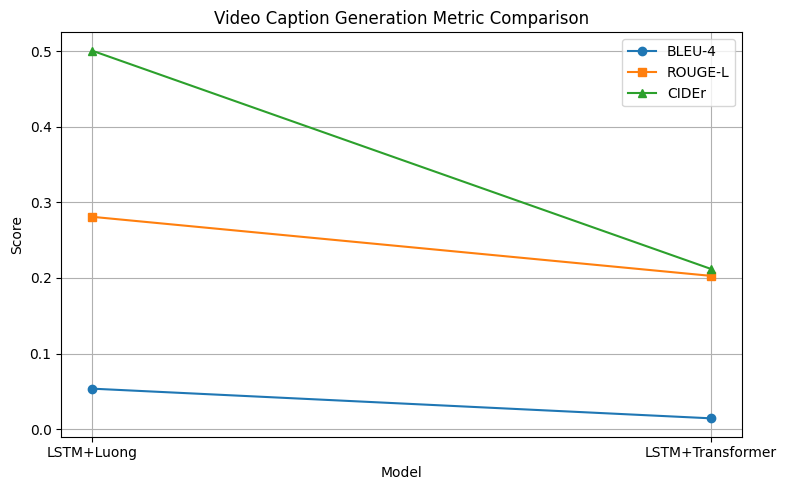

In [2]:
import matplotlib.pyplot as plt

models = ['LSTM+Luong', 'LSTM+Transformer']
bleu = [0.0535, 0.0142]
rouge = [0.281, 0.2028]
cider = [0.5009, 0.2119]

plt.figure(figsize=(8, 5))
plt.plot(models, bleu, marker='o', label='BLEU-4')
plt.plot(models, rouge, marker='s', label='ROUGE-L')
plt.plot(models, cider, marker='^', label='CIDEr')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Video Caption Generation Metric Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#bidirectional=True +transformer
import torch
import numpy as np
import os
import random
from tqdm import tqdm

#  Load the best saved checkpoint

ckpt = torch.load("best_checkpoint_metrics.pth", map_location=DEVICE)
enc.load_state_dict(ckpt['enc_state'])
dec.load_state_dict(ckpt['dec_state'])
print(" Loaded checkpoint successfully.")


#Evaluate on test set

print("Running test evaluation (BLEU, ROUGE, CIDEr)...")
test_bleu, test_rouge, test_cider = evaluate_with_metrics(test_loader, enc, dec, vocab, DEVICE)
print(f"\n📊 Test Metrics:\nBLEU-4 = {test_bleu:.4f}\nROUGE-L = {test_rouge:.4f}\nCIDEr = {test_cider:.4f}")

#  Function to generate caption for a single video

def generate_caption_for_video(video_feat, enc, dec, vocab, device, max_len=20):
    enc.eval()
    dec.eval()

    feat_tensor = torch.tensor(video_feat).unsqueeze(0).float().to(device)  # (1, T, D)
    with torch.no_grad():
        enc_outs = enc(feat_tensor)
     

        input_seq = torch.LongTensor([[vocab.word2idx[vocab.bos_token]]]).to(device)
        generated_tokens = []

        for _ in range(max_len):
            out = dec(enc_outs, input_seq)
            next_word = out[:, -1, :].argmax(-1).item()
            if next_word == vocab.word2idx[vocab.eos_token]:
                break
            generated_tokens.append(vocab.idx2word.get(next_word, vocab.unk_token))
            input_seq = torch.cat([input_seq, torch.LongTensor([[next_word]]).to(device)], dim=1)

    return " ".join(generated_tokens)
    
def predict_for_selected_videos(selected_vids, features_dir, test_items, enc, dec, vocab, device, max_len=20):
   
    print("\n--- Selected Video Predictions ---")
    for i, vid in enumerate(selected_vids):
        feat_path = os.path.join(features_dir, vid.replace('.mp4', '.npy'))
        if not os.path.exists(feat_path):
            print(f" Feature file missing for {vid}")
            continue

        video_feat = np.load(feat_path)
        generated_caption = generate_caption_for_video(video_feat, enc, dec, vocab, device, max_len)
        references = test_items.get(vid, [])

        print(f"\nVideo {i+1}: {vid}")
        print(f"Generated Caption: {generated_caption}")
        print("Reference Captions:")
        for j, ref in enumerate(references[:3]):  # show up to 3 refs
            print(f"  Ref {j+1}: {ref}")

# Example: Choose specific video IDs from your test set
selected_vids = [
    "video6643.mp4",
    "video1850.mp4",
    "video4829.mp4",
    "video8925.mp4"
]

predict_for_selected_videos(
    selected_vids,
    FEATURES_DIR,
    test_items,
    enc,
    dec,
    vocab,
    DEVICE,
    max_len=20
)

# =====================================
# 🔹 Pick a few random test samples
# =====================================
sample_videos = random.sample(list(test_items.keys()), 4)

print("\n --- Random Sample Predictions ---")
for i, vid in enumerate(sample_videos):
    sample_feat_path = os.path.join(FEATURES_DIR, vid.replace('.mp4', '.npy'))
    sample_feat = np.load(sample_feat_path)

    generated_caption = generate_caption_for_video(sample_feat, enc, dec, vocab, DEVICE)
    references = test_items[vid]  # list of ground-truth captions

    print(f"\n Video {i+1}: {vid}")
    print(f"Generated Caption: {generated_caption}")
    print("Reference Captions:")
    for j, ref in enumerate(references[:3]):  # print up to 3 refs
        print(f"  Ref {j+1}: {ref}")


 Loaded checkpoint successfully.
Running test evaluation (BLEU, ROUGE, CIDEr)...


100%|██████████| 625/625 [00:51<00:00, 12.03it/s]



📊 Test Metrics:
BLEU-4 = 0.0132
ROUGE-L = 0.1949
CIDEr = 0.1782

--- Selected Video Predictions ---

Video 1: video6643.mp4
Generated Caption: a man is talking about something
Reference Captions:
  Ref 1: a clip showing a man giving instructions to others
  Ref 2: a guy is giving a speech in front of an audience
  Ref 3: a man giving a motavational speech

Video 2: video1850.mp4
Generated Caption: a man in a suit is talking about the latest news
Reference Captions:
  Ref 1: a gray haired news anchor with a purple tie discusses an election
  Ref 2: there is a suit man is talking about election
  Ref 3: there is a suit man is talking about politics

Video 3: video4829.mp4
Generated Caption: a woman is talking to another woman
Reference Captions:
  Ref 1: a couple is singing different parts of the same song
  Ref 2: a couple is watching a movie
  Ref 3: a couple singing a song

Video 4: video8925.mp4
Generated Caption: a band is playing on stage
Reference Captions:
  Ref 1: a band is per

Other experiments done: Spatial+temporal attention:

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialTemporalAttention(nn.Module):
    """
    Add lightweight spatial + temporal attention between encoder and decoder.
    Works with (B, T, D_enc) encoder outputs.
    """
    def __init__(self, enc_dim, use_spatial=False):
        super().__init__()
        self.enc_dim = enc_dim
        self.use_spatial = use_spatial

        # Temporal attention: learns to weight frames
        self.temporal_attn = nn.Sequential(
            nn.Linear(enc_dim, enc_dim // 2),
            nn.Tanh(),
            nn.Linear(enc_dim // 2, 1)
        )

       
        if use_spatial:
            self.spatial_attn = nn.Sequential(
                nn.Linear(enc_dim, enc_dim // 2),
                nn.Tanh(),
                nn.Linear(enc_dim // 2, 1)
            )

    def forward(self, enc_outs, spatial_feats=None):
        """
        enc_outs: (B, T, D_enc)
        spatial_feats (optional): (B, T, R, D_enc)
        """
        # 1️ Spatial attention (optional)
        if self.use_spatial and spatial_feats is not None:
            attn_weights = F.softmax(self.spatial_attn(spatial_feats).squeeze(-1), dim=-1)  # (B,T,R)
            spatial_context = (attn_weights.unsqueeze(-1) * spatial_feats).sum(dim=2)      # (B,T,D)
            enc_outs = enc_outs + spatial_context  # residual fusion

        # 2️ Temporal attention
        energy = self.temporal_attn(enc_outs).squeeze(-1)      # (B,T)
        weights = F.softmax(energy, dim=-1).unsqueeze(-1)      # (B,T,1)
        attended = (weights * enc_outs).sum(dim=1, keepdim=True)  # (B,1,D)

        # Optionally repeat context for decoder
        refined_outs = attended.repeat(1, enc_outs.size(1), 1)
        return refined_outs


In [35]:
FEATURE_DIM = 2048
ENC_HIDDEN = 512
EMBED_SIZE = 512
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

enc = EncoderLSTM(feat_dim=FEATURE_DIM, hidden_dim=ENC_HIDDEN).to(DEVICE)
dec = TransformerDecoderNoAttn(
    vocab_size=len(vocab.word2idx),
    embed_dim=EMBED_SIZE,
    enc_dim=enc.output_dim,
    num_layers=3
).to(DEVICE)

# ✅ Add the attention bridge
attn_refiner = SpatialTemporalAttention(enc_dim=enc.output_dim).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx[vocab.pad_token])
params = list(enc.parameters()) + list(dec.parameters()) + list(attn_refiner.parameters())
optimizer = optim.Adam(params, lr=LR)


In [36]:
def train_one_epoch(train_loader, enc, dec, attn_refiner, optimizer, criterion, device, clip=5.0):
    enc.train(); dec.train(); attn_refiner.train()
    running_loss = 0.0

    for feats, caps, cap_lens in tqdm(train_loader):
        feats, caps = feats.to(device), caps.to(device)
        optimizer.zero_grad()

        encoder_outs = enc(feats)                        # (B, T, D_enc)
        refined_enc_outs = attn_refiner(encoder_outs)    # (B, T, D_enc) — attended features

        outputs = dec(refined_enc_outs, caps[:, :-1])
        targets = caps[:, 1:]

        loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params, clip)
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


In [87]:
best_bleu = 0.0
EPOCHS = 10

for epoch in range(1, EPOCHS+1):
    # Train
    train_loss = train_one_epoch(train_loader, enc, dec, attn_refiner, optimizer, criterion, DEVICE)
    print(f"[Epoch {epoch}] Train loss: {train_loss:.4f}")

    # Validate with metrics
    bleu, rouge_l, cider = evaluate_with_metrics(val_loader, enc, dec,attn_refiner, vocab, DEVICE)
    print(f"[Epoch {epoch}] Validation Metrics: BLEU-4={bleu:.4f}, ROUGE-L={rouge_l:.4f}, CIDEr={cider:.4f}")

    # Save best BLEU model
    if bleu > best_bleu:
        best_bleu = bleu
        torch.save({
            'enc_state': enc.state_dict(),
            'dec_state': dec.state_dict(),
            'vocab': vocab.word2idx
        }, "best_checkpoint_metrics.pth")
        print(f" Saved new best model at epoch {epoch} with BLEU={bleu:.4f}")


100%|██████████| 5000/5000 [05:08<00:00, 16.20it/s]


[Epoch 1] Train loss: 4.1122


100%|██████████| 625/625 [00:51<00:00, 12.18it/s]


[Epoch 1] Validation Metrics: BLEU-4=0.0110, ROUGE-L=0.1772, CIDEr=0.1015
 Saved new best model at epoch 1 with BLEU=0.0110


100%|██████████| 5000/5000 [05:05<00:00, 16.34it/s]


[Epoch 2] Train loss: 3.4253


100%|██████████| 625/625 [00:51<00:00, 12.24it/s]


[Epoch 2] Validation Metrics: BLEU-4=0.0110, ROUGE-L=0.1765, CIDEr=0.1349
 Saved new best model at epoch 2 with BLEU=0.0110


100%|██████████| 5000/5000 [05:06<00:00, 16.33it/s]


[Epoch 3] Train loss: 3.1480


100%|██████████| 625/625 [00:52<00:00, 11.97it/s]


[Epoch 3] Validation Metrics: BLEU-4=0.0104, ROUGE-L=0.1979, CIDEr=0.1799


100%|██████████| 5000/5000 [05:05<00:00, 16.35it/s]


[Epoch 4] Train loss: 2.9532


100%|██████████| 625/625 [00:51<00:00, 12.17it/s]


[Epoch 4] Validation Metrics: BLEU-4=0.0114, ROUGE-L=0.1960, CIDEr=0.1723
 Saved new best model at epoch 4 with BLEU=0.0114


100%|██████████| 5000/5000 [05:06<00:00, 16.33it/s]


[Epoch 5] Train loss: 2.7999


100%|██████████| 625/625 [00:51<00:00, 12.15it/s]


[Epoch 5] Validation Metrics: BLEU-4=0.0126, ROUGE-L=0.1890, CIDEr=0.1669
 Saved new best model at epoch 5 with BLEU=0.0126


100%|██████████| 5000/5000 [05:06<00:00, 16.33it/s]


[Epoch 6] Train loss: 2.6737


100%|██████████| 625/625 [00:51<00:00, 12.07it/s]


[Epoch 6] Validation Metrics: BLEU-4=0.0106, ROUGE-L=0.1837, CIDEr=0.1465


100%|██████████| 5000/5000 [05:05<00:00, 16.34it/s]


[Epoch 7] Train loss: 2.5680


100%|██████████| 625/625 [00:52<00:00, 12.01it/s]


[Epoch 7] Validation Metrics: BLEU-4=0.0117, ROUGE-L=0.1879, CIDEr=0.1537


100%|██████████| 5000/5000 [05:06<00:00, 16.33it/s]


[Epoch 8] Train loss: 2.4735


100%|██████████| 625/625 [00:51<00:00, 12.05it/s]


[Epoch 8] Validation Metrics: BLEU-4=0.0102, ROUGE-L=0.1757, CIDEr=0.1229


100%|██████████| 5000/5000 [05:05<00:00, 16.36it/s]


[Epoch 9] Train loss: 2.3901


100%|██████████| 625/625 [00:51<00:00, 12.15it/s]


[Epoch 9] Validation Metrics: BLEU-4=0.0106, ROUGE-L=0.1929, CIDEr=0.1593


100%|██████████| 5000/5000 [05:06<00:00, 16.34it/s]


[Epoch 10] Train loss: 2.3158


100%|██████████| 625/625 [00:51<00:00, 12.20it/s]


[Epoch 10] Validation Metrics: BLEU-4=0.0104, ROUGE-L=0.1873, CIDEr=0.1519


In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
import numpy as np
import torch
from tqdm import tqdm

def evaluate_with_metrics(loader, enc, dec, attn_refiner,vocab, device, max_len=20):
    enc.eval()
    dec.eval()
    all_refs = []
    all_preds = []

    with torch.no_grad():
        for feats, caps,cap_lens in tqdm(loader):
            feats = feats.to(device)
            caps = caps.to(device)

            # Encoder forward
            encoder_outs = enc(feats)  # (B, T_enc, enc_dim)

            encoder_outs = attn_refiner(encoder_outs)

            # Greedy decoding
            batch_size = feats.size(0)
            input_word = torch.LongTensor([vocab.word2idx[vocab.bos_token]] * batch_size).to(device)
            preds = torch.zeros(batch_size, max_len).long().to(device)

            for t in range(max_len):
                out = dec(encoder_outs, input_word.unsqueeze(1))  # (B, 1, vocab_size)
                next_word = out[:, -1, :].argmax(-1)
                preds[:, t] = next_word
                input_word = next_word 

            # Convert preds and refs to token lists
            for i in range(batch_size):
              
                p = []
                for tok in preds[i].cpu().numpy():
                    if tok == vocab.word2idx[vocab.eos_token]:
                        break
                    if tok in (vocab.word2idx[vocab.pad_token], vocab.word2idx[vocab.bos_token]):
                        continue
                    p.append(vocab.idx2word.get(tok, vocab.unk_token))
                all_preds.append(p)

                # Reference tokens
                ref_tokens = []
                for tok in caps[i].cpu().numpy():
                    if tok == vocab.word2idx[vocab.eos_token]:
                        break
                    if tok in (vocab.word2idx[vocab.pad_token], vocab.word2idx[vocab.bos_token]):
                        continue
                    ref_tokens.append(vocab.idx2word.get(int(tok), vocab.unk_token))
                all_refs.append([ref_tokens])  

  
    # Compute metrics
    smoothie = SmoothingFunction().method4
    bleu4 = corpus_bleu(all_refs, all_preds, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

  

    # ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l_f1s = [scorer.score(" ".join(ref[0]), " ".join(pred))['rougeL'].fmeasure for ref, pred in zip(all_refs, all_preds)]
    rouge_l = np.mean(rouge_l_f1s)

  #CidER
    cider_scorer = Cider()
    refs_for_cider = {i: [" ".join(r[0]) for r in all_refs[i:i+1]] for i in range(len(all_refs))}
    preds_for_cider = {i: [" ".join(all_preds[i])] for i in range(len(all_preds))} 
    cider_score, _ = cider_scorer.compute_score(refs_for_cider, preds_for_cider)


    return bleu4 ,rouge_l, cider_score


In [ ]:
import torch
import numpy as np
import os
import random
from tqdm import tqdm


#  Load the best saved checkpoint
ckpt = torch.load("best_checkpoint_metrics.pth", map_location=DEVICE)
enc.load_state_dict(ckpt['enc_state'])
dec.load_state_dict(ckpt['dec_state'])
print(" Loaded checkpoint successfully.")



#  Evaluate on test set
print("Running test evaluation (BLEU, ROUGE, CIDEr)...")
test_bleu, test_rouge, test_cider = evaluate_with_metrics(test_loader, enc, dec, vocab, DEVICE)
print(f"\n📊 Test Metrics:\nBLEU-4 = {test_bleu:.4f}\nROUGE-L = {test_rouge:.4f}\nCIDEr = {test_cider:.4f}")



def generate_caption_for_video(video_feat, enc, dec, vocab, device, max_len=20):
    enc.eval()
    dec.eval()

    feat_tensor = torch.tensor(video_feat).unsqueeze(0).float().to(device)  # (1, T, D)
    with torch.no_grad():
        enc_outs = enc(feat_tensor)


        input_seq = torch.LongTensor([[vocab.word2idx[vocab.bos_token]]]).to(device)
        generated_tokens = []

        for _ in range(max_len):
            out = dec(enc_outs, input_seq)
            next_word = out[:, -1, :].argmax(-1).item()
            if next_word == vocab.word2idx[vocab.eos_token]:
                break
            generated_tokens.append(vocab.idx2word.get(next_word, vocab.unk_token))
            input_seq = torch.cat([input_seq, torch.LongTensor([[next_word]]).to(device)], dim=1)

    return " ".join(generated_tokens)

# few random test samples
sample_videos = random.sample(list(test_items.keys()), 4)

print("\n --- Random Sample Predictions ---")
for i, vid in enumerate(sample_videos):
    sample_feat_path = os.path.join(FEATURES_DIR, vid.replace('.mp4', '.npy'))
    sample_feat = np.load(sample_feat_path)

    generated_caption = generate_caption_for_video(sample_feat, enc, dec, vocab, DEVICE)
    references = test_items[vid] 

    print(f"\n Video {i+1}: {vid}")
    print(f"Generated Caption: {generated_caption}")
    print("Reference Captions:")
    for j, ref in enumerate(references[:3]): 
        print(f"  Ref {j+1}: {ref}")


 Loaded checkpoint successfully.
Running test evaluation (BLEU, ROUGE, CIDEr)...


100%|██████████| 625/625 [00:50<00:00, 12.30it/s]



📊 Test Metrics:
BLEU-4 = 0.0107
ROUGE-L = 0.1760
CIDEr = 0.1489

 --- Random Sample Predictions ---

 Video 1: video3818.mp4
Generated Caption: a man is playing a game of ping pong
Reference Captions:
  Ref 1: a child preforms a gymnastics preformance
  Ref 2: a female gymnast is jumping
  Ref 3: a girl is doing gymnastics on the mat

 Video 2: video350.mp4
Generated Caption: a man is playing a video game
Reference Captions:
  Ref 1: a game is being played
  Ref 2: a gamer is playing minecraft
  Ref 3: a man and a woman playing a video  game

 Video 3: video2520.mp4
Generated Caption: a man is looking at a car
Reference Captions:
  Ref 1: a cartoon about a boy
  Ref 2: a cartoon character swims in rough waters
  Ref 3: a cartoon of a boy in the ocean

 Video 4: video4377.mp4
Generated Caption: a woman is singing a song in a music video
Reference Captions:
  Ref 1: rihanna wears camouflage pants a white top and sings on top of a car
  Ref 2: rihanna wears large hoop earrings and sings 